In [1]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm
from scipy.signal import stft
from scipy.stats import kurtosis
from torchsummary import summary
from tabulate import tabulate

/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [3]:
datasets.Dataset('PRONOSTIA').describe()

PRONOSTIA

Description
The IEEE PHM data challenge in 2012 utilized a renowned dataset provided by the FEMTO-ST Institute. The dataset originated from experiments conducted on a laboratory experimental platform known as PRONOSTIA, designed for accelerated degradation testing of bearings under various operating conditions. During these experiments, online health monitoring data including rotating speed, load force, temperature, and vibration were collected.

The dataset considered data from three different loads, encompassing rotating speed and load force variations. A total of 6 run-to-failure bearings were designated for building prognostic models, while an additional 11 bearings were allocated for testing purposes.

One notable characteristic of the challenge datasets was the relatively small amount of training data available, coupled with a high variability in experiment durations ranging from 1 to 7 hours. This variability posed a significant challenge in accurately estimating prog

In [4]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:35<00:00, 392.13it/s]
INFO:root:Read in 59.0186665058136 seconds


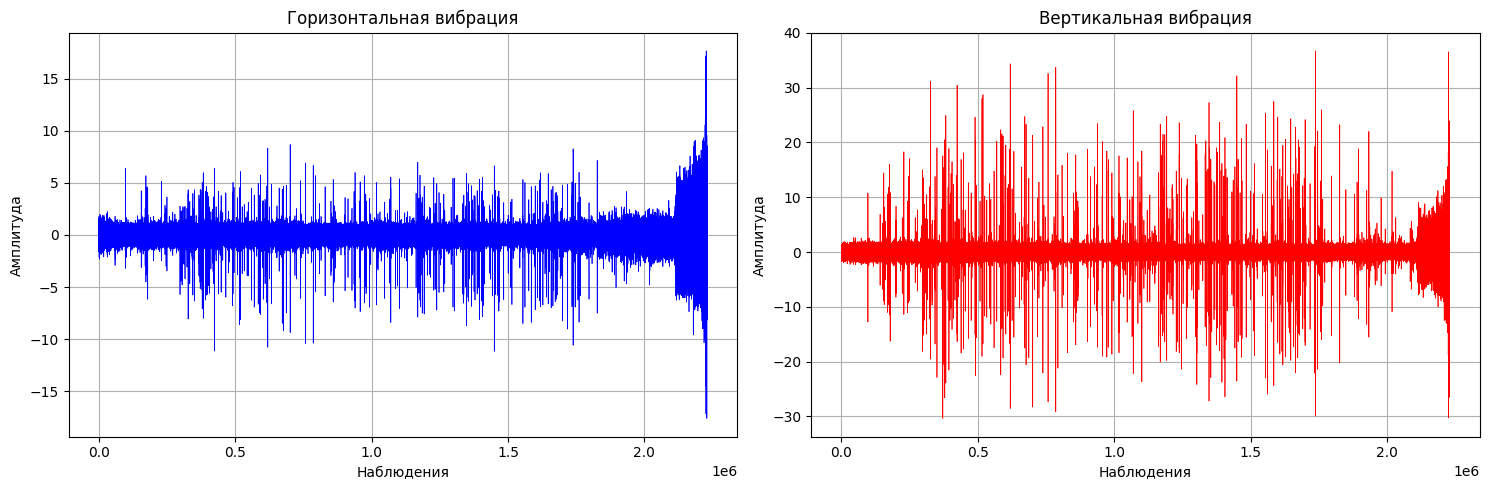

In [5]:
d_1_1 = df[0][df[0]['unit'] == '1_1']
d_1_2 = df[0][df[0]['unit'] == '1_2']
d_2_1 = df[0][df[0]['unit'] == '2_1']
d_2_2 = df[0][df[0]['unit'] == '2_2']
d_3_1 = df[0][df[0]['unit'] == '3_1']
d_3_2 = df[0][df[0]['unit'] == '3_2']

# Create a figure with 1 row and 2 columns (side-by-side plots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot H_acc (horizontal vibration) on the left
ax1.plot(d_1_2['H_acc'], color='blue', linewidth=0.5)
ax1.set_title('Горизонтальная вибрация')
ax1.set_xlabel('Наблюдения')
ax1.set_ylabel('Амплитуда')
ax1.grid(True)

# Plot V_acc (vertical vibration) on the right
ax2.plot(d_1_2['V_acc'], color='red', linewidth=0.5)
ax2.set_title('Вертикальная вибрация')
ax2.set_xlabel('Наблюдения')
ax2.set_ylabel('Амплитуда')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

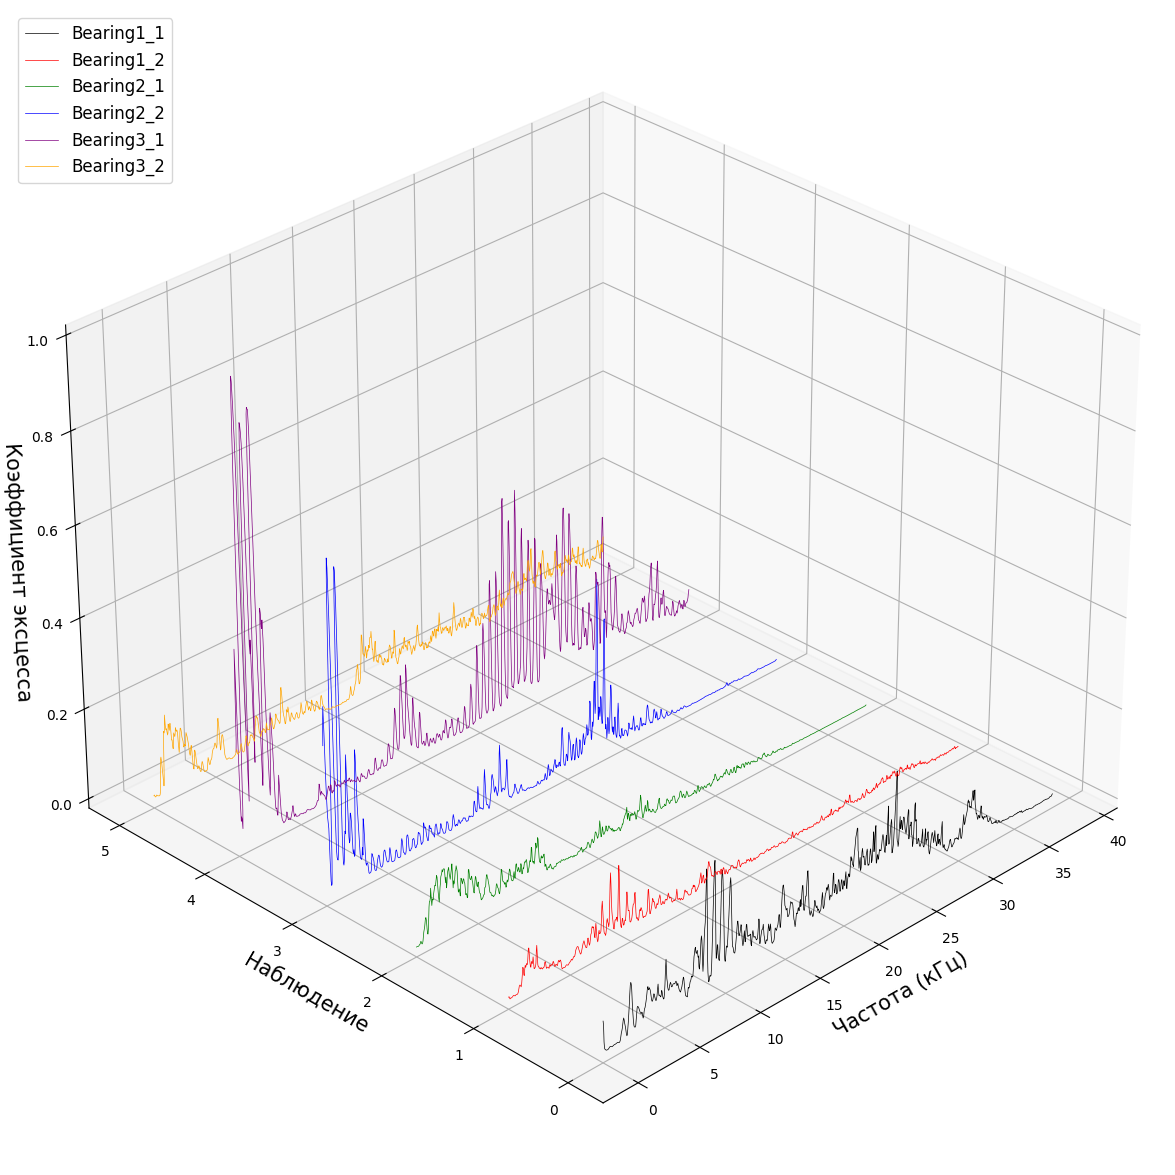

In [6]:
f = []
ffts = []

nperseg = 1024
TRAIN_BEARINGS_LIST = [bearing for bearings_list in TRAIN_BEARINGS.values() for bearing in bearings_list]
LABEL_COLORS = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'blue',
    4: 'purple',
    5: 'orange',
}

for bearing in TRAIN_BEARINGS_LIST:
    data = df[0][df[0]['unit'] == bearing]
    vibration_signal = (data['H_acc'] - np.mean(data['H_acc'])) / np.std(data['H_acc'])
    u,v,w = stft(vibration_signal, 25.6 * 1000, nperseg=nperseg,noverlap = 512, window='hann', nfft=2048)
    f.append(u)
    ffts.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
ffts = np.asarray(ffts)

fftn = (ffts - ffts.min()) / (ffts.max() - ffts.min())

fftn = np.asarray(fftn)


def plot_3d_bearing_kurtosis(f, bearings_list, label_colors):
    n = np.ones_like(f[0])

    fig = plt.figure(figsize = (15.0, 15.0))
    ax = plt.axes(projection = '3d')
    ax.view_init(30,225)
    for i in range(f.shape[0]):
        ax.plot(
            (f[i] * 3) / 1.0e3,
            i * n,
            fftn[i],
            color=label_colors[i],
            linewidth = 0.50,
            label='Bearing' + bearings_list[i],
        )

    ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Частота (кГц)', fontsize=15)
    ax.set_ylabel('Наблюдение', fontsize=15)
    ax.set_zlabel('Коэффициент эксцесса', fontsize=15)
    plt.show()

plot_3d_bearing_kurtosis(
    f=f,
    bearings_list=TRAIN_BEARINGS_LIST,
    label_colors=LABEL_COLORS
)

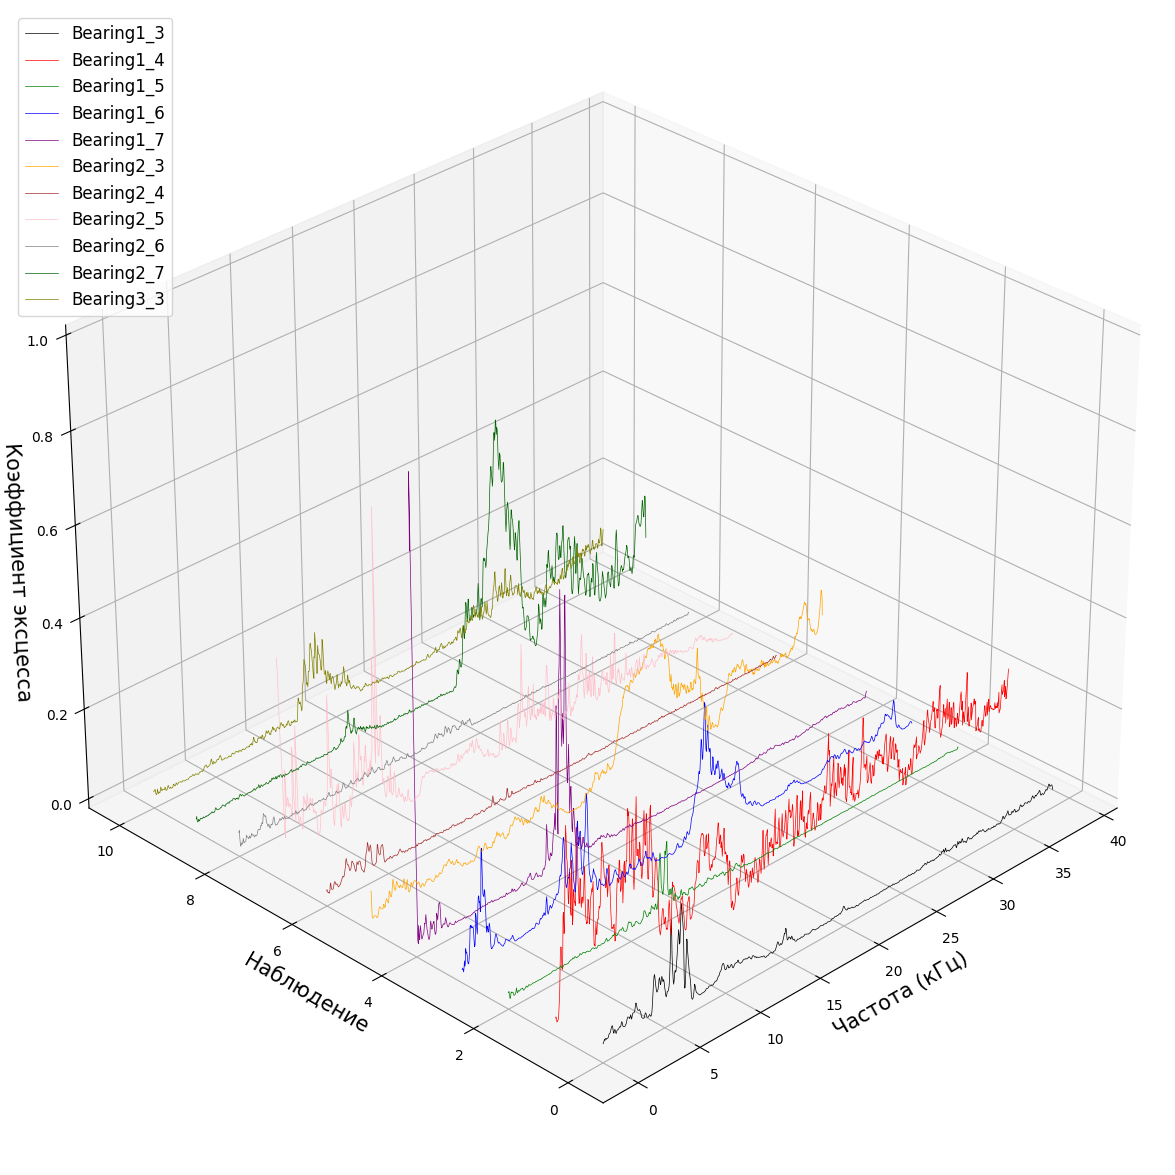

In [7]:
f = []
ffts = []

nperseg = 1024
TEST_BEARINGS_LIST = [bearing for bearings_list in TEST_BEARINGS.values() for bearing in bearings_list]
LABEL_COLORS = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'blue',
    4: 'purple',
    5: 'orange',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'darkgreen',
    10: 'olive',
}

for bearing in TEST_BEARINGS_LIST:
    data = df[1][df[1]['unit'] == bearing]
    vibration_signal = (data['H_acc'] - np.mean(data['H_acc'])) / np.std(data['H_acc'])
    u,v,w = stft(vibration_signal, 25.6 * 1000, nperseg=nperseg,noverlap = 512, window='hann', nfft=2048)
    f.append(u)
    ffts.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
ffts = np.asarray(ffts)

fftn = (ffts - ffts.min()) / (ffts.max() - ffts.min())

fftn = np.asarray(fftn)

plot_3d_bearing_kurtosis(
    f=f,
    bearings_list=TEST_BEARINGS_LIST,
    label_colors=LABEL_COLORS
)

In [8]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [9]:
df[0].head(5)

,unit,V_acc,rul,H_acc
0,1_1,-0.146,28029,0.552
1,1_1,-0.480,28029,0.501
2,1_1,0.435,28029,0.138
3,1_1,0.240,28029,-0.423
4,1_1,0.020,28029,-0.802


In [10]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [11]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
2229755    1_2
2229756    1_2
2229757    1_2
2229758    1_2
2229759    1_2
Name: unit, Length: 9405440, dtype: object

In [12]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,unit,V_acc,rul,H_acc
0,1_1,-0.146,28029,0.552
1,1_1,-0.480,28029,0.501
2,1_1,0.435,28029,0.138
3,1_1,0.240,28029,-0.423
4,1_1,0.020,28029,-0.802
...,...,...,...,...
2229755,1_2,3.622,0,-2.595
2229756,1_2,8.675,0,-2.869
2229757,1_2,8.111,0,1.457
2229758,1_2,1.403,0,1.591


In [13]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,unit,V_acc,rul,H_acc
0,1_3,0.044,23749,0.092
1,1_3,0.432,23749,-0.025
2,1_3,0.008,23749,-0.104
3,1_3,-0.264,23749,0.056
4,1_3,-0.195,23749,0.074
...,...,...,...,...
3845115,1_7,-0.013,7570,0.481
3845116,1_7,-0.272,7570,0.191
3845117,1_7,0.466,7570,0.250
3845118,1_7,-0.582,7570,0.001


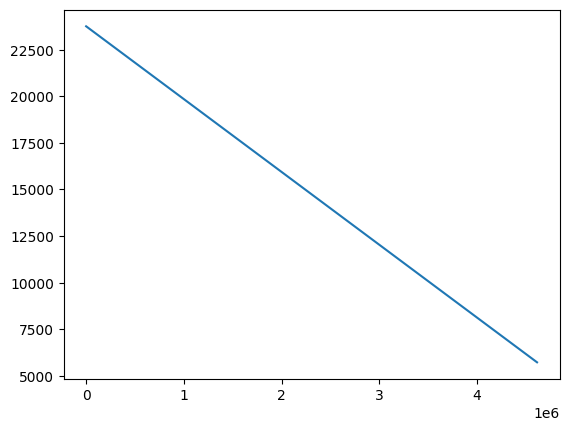

In [14]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [15]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for _, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['1_1'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_7'],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '1_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
len(train_dataset), train_dataset[0][0].shape

(5604, torch.Size([2560, 2]))

In [17]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super(BearingCNN, self).__init__()
        
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, stride=1, padding=2),  # [32, 16, 2560]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                  # [32, 16, 1280]
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),  # [32, 32, 1280]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                  # [32, 32, 640]
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # [32, 64, 640]
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)                                 # [32, 64, 1]
        )
        
        # Regressor
        self.regressor = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.features(x)       # [32, 64, 1]
        x = x.squeeze(-1)          # [32, 64]
        x = self.regressor(x)      # [32, 1]
        return x

model = BearingCNN()
# model.load_state_dict(torch.load('last_r2_model.pth', weights_only=True))

In [18]:
# def model_summary_table(model, input_shape):
#     # Get summary as a string
#     summary_str = []
#     def hook(module, input, output):
#         summary_str.append([
#             module.__class__.__name__,
#             list(input[0].shape) if isinstance(input, tuple) else input.shape,
#             list(output.shape),
#             sum(p.numel() for p in module.parameters())
#         ])
    
#     # Register hooks
#     hooks = []
#     for layer in model.children():
#         hooks.append(layer.register_forward_hook(hook))
    
#     # Dummy forward pass
#     dummy_input = torch.randn(input_shape)
#     model(dummy_input)
    
#     # Remove hooks
#     for hook in hooks:
#         hook.remove()
    
#     # Print table
#     headers = ["Layer (type)", "Input Shape", "Output Shape", "Param #"]
#     print(tabulate(summary_str, headers=headers, tablefmt="grid"))

# summary(model, input_size=(2560, 2), batch_size=32, device='cpu')

In [134]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

def r2_score_loss(y_pred, y_true):
    # Calculate R² (Coefficient of Determination)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero
    return -r2  # Minimize this (equivalent to maximizing R²)

def hybrid_r2_mse_loss(alpha = 0.2):
    def loss_fn(y_pred, y_true):
        mse = torch.mean((y_pred - y_true) ** 2)
        r2 = r2_score_loss(y_pred, y_true)  # Returns -R²
        return alpha * mse + (1 - alpha) * r2
    
    return loss_fn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = hybrid_r2_mse_loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val)

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    torch.save(model.state_dict(), 'last_r2_model.pth')

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [31]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 100)

train_results

100%|██████████| 176/176 [00:00<00:00, 249.24it/s]


Epoch 1: Train Loss 36157.5983, Train R2 = -0.456, Train RMSE = 0.348, Train MSE = 0.121, Train MAE = 0.207


Epoch 1 Val: 100%|██████████| 55/55 [00:00<00:00, 496.02it/s]


Epoch 1: Val Loss 7429.6194, Val R2 = -2.173, Val RMSE = 0.514, Val MSE = 0.264, Val MAE = 0.429


100%|██████████| 176/176 [00:00<00:00, 255.94it/s]


Epoch 2: Train Loss 25616.5450, Train R2 = -0.045, Train RMSE = 0.295, Train MSE = 0.087, Train MAE = 0.185


Epoch 2 Val: 100%|██████████| 55/55 [00:00<00:00, 487.41it/s]


Epoch 2: Val Loss 6856.0627, Val R2 = -1.920, Val RMSE = 0.493, Val MSE = 0.243, Val MAE = 0.409


100%|██████████| 176/176 [00:00<00:00, 260.98it/s]


Epoch 3: Train Loss 25287.8687, Train R2 = 0.060, Train RMSE = 0.280, Train MSE = 0.078, Train MAE = 0.187


Epoch 3 Val: 100%|██████████| 55/55 [00:00<00:00, 563.73it/s]


Epoch 3: Val Loss 7104.1897, Val R2 = -2.029, Val RMSE = 0.502, Val MSE = 0.252, Val MAE = 0.418


100%|██████████| 176/176 [00:00<00:00, 266.64it/s]


Epoch 4: Train Loss 64952.5612, Train R2 = -1.493, Train RMSE = 0.456, Train MSE = 0.208, Train MAE = 0.349


Epoch 4 Val: 100%|██████████| 55/55 [00:00<00:00, 519.58it/s]


Epoch 4: Val Loss 3710.9072, Val R2 = -0.578, Val RMSE = 0.362, Val MSE = 0.131, Val MAE = 0.293


100%|██████████| 176/176 [00:00<00:00, 256.83it/s]


Epoch 5: Train Loss 41835.9630, Train R2 = 0.130, Train RMSE = 0.269, Train MSE = 0.072, Train MAE = 0.226


Epoch 5 Val: 100%|██████████| 55/55 [00:00<00:00, 529.22it/s]


Epoch 5: Val Loss 3876.3636, Val R2 = -0.497, Val RMSE = 0.353, Val MSE = 0.124, Val MAE = 0.291


100%|██████████| 176/176 [00:00<00:00, 279.64it/s]


Epoch 6: Train Loss 43992.8509, Train R2 = -0.798, Train RMSE = 0.387, Train MSE = 0.150, Train MAE = 0.310


Epoch 6 Val: 100%|██████████| 55/55 [00:00<00:00, 551.82it/s]


Epoch 6: Val Loss 3591.5418, Val R2 = -0.518, Val RMSE = 0.355, Val MSE = 0.126, Val MAE = 0.289


100%|██████████| 176/176 [00:00<00:00, 287.84it/s]


Epoch 7: Train Loss 29100.2840, Train R2 = -0.111, Train RMSE = 0.304, Train MSE = 0.093, Train MAE = 0.247


Epoch 7 Val: 100%|██████████| 55/55 [00:00<00:00, 598.70it/s]


Epoch 7: Val Loss 3080.0040, Val R2 = -0.310, Val RMSE = 0.330, Val MSE = 0.109, Val MAE = 0.270


100%|██████████| 176/176 [00:00<00:00, 270.19it/s]


Epoch 8: Train Loss 20972.8728, Train R2 = 0.166, Train RMSE = 0.264, Train MSE = 0.069, Train MAE = 0.218


Epoch 8 Val: 100%|██████████| 55/55 [00:00<00:00, 574.68it/s]


Epoch 8: Val Loss 3425.7360, Val R2 = -0.450, Val RMSE = 0.347, Val MSE = 0.121, Val MAE = 0.282


100%|██████████| 176/176 [00:00<00:00, 247.85it/s]


Epoch 9: Train Loss 24054.4892, Train R2 = 0.045, Train RMSE = 0.282, Train MSE = 0.080, Train MAE = 0.233


Epoch 9 Val: 100%|██████████| 55/55 [00:00<00:00, 543.09it/s]


Epoch 9: Val Loss 2976.2736, Val R2 = -0.231, Val RMSE = 0.320, Val MSE = 0.102, Val MAE = 0.265


100%|██████████| 176/176 [00:00<00:00, 256.69it/s]


Epoch 10: Train Loss 23841.5286, Train R2 = 0.096, Train RMSE = 0.274, Train MSE = 0.075, Train MAE = 0.221


Epoch 10 Val: 100%|██████████| 55/55 [00:00<00:00, 517.39it/s]


Epoch 10: Val Loss 2779.4520, Val R2 = -0.180, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.258


100%|██████████| 176/176 [00:00<00:00, 265.12it/s]


Epoch 11: Train Loss 18219.1232, Train R2 = 0.303, Train RMSE = 0.241, Train MSE = 0.058, Train MAE = 0.204


Epoch 11 Val: 100%|██████████| 55/55 [00:00<00:00, 503.88it/s]


Epoch 11: Val Loss 2836.8970, Val R2 = -0.169, Val RMSE = 0.312, Val MSE = 0.097, Val MAE = 0.259


100%|██████████| 176/176 [00:00<00:00, 257.87it/s]


Epoch 12: Train Loss 20112.6588, Train R2 = 0.226, Train RMSE = 0.254, Train MSE = 0.064, Train MAE = 0.201


Epoch 12 Val: 100%|██████████| 55/55 [00:00<00:00, 476.12it/s]


Epoch 12: Val Loss 2758.0288, Val R2 = -0.170, Val RMSE = 0.312, Val MSE = 0.097, Val MAE = 0.256


100%|██████████| 176/176 [00:00<00:00, 257.58it/s]


Epoch 13: Train Loss 18410.4902, Train R2 = 0.514, Train RMSE = 0.201, Train MSE = 0.040, Train MAE = 0.155


Epoch 13 Val: 100%|██████████| 55/55 [00:00<00:00, 462.14it/s]


Epoch 13: Val Loss 3337.1103, Val R2 = -0.425, Val RMSE = 0.344, Val MSE = 0.119, Val MAE = 0.276


100%|██████████| 176/176 [00:00<00:00, 259.80it/s]


Epoch 14: Train Loss 18192.7908, Train R2 = 0.331, Train RMSE = 0.236, Train MSE = 0.056, Train MAE = 0.193


Epoch 14 Val: 100%|██████████| 55/55 [00:00<00:00, 434.57it/s]


Epoch 14: Val Loss 3050.5690, Val R2 = -0.251, Val RMSE = 0.323, Val MSE = 0.104, Val MAE = 0.266


100%|██████████| 176/176 [00:00<00:00, 245.50it/s]


Epoch 15: Train Loss 20426.9569, Train R2 = 0.168, Train RMSE = 0.263, Train MSE = 0.069, Train MAE = 0.202


Epoch 15 Val: 100%|██████████| 55/55 [00:00<00:00, 523.27it/s]


Epoch 15: Val Loss 2818.0026, Val R2 = -0.191, Val RMSE = 0.315, Val MSE = 0.099, Val MAE = 0.257


100%|██████████| 176/176 [00:00<00:00, 254.94it/s]


Epoch 16: Train Loss 12986.0072, Train R2 = 0.475, Train RMSE = 0.209, Train MSE = 0.044, Train MAE = 0.161


Epoch 16 Val: 100%|██████████| 55/55 [00:00<00:00, 564.55it/s]


Epoch 16: Val Loss 2790.0878, Val R2 = -0.181, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.255


100%|██████████| 176/176 [00:00<00:00, 261.99it/s]


Epoch 17: Train Loss 11075.1886, Train R2 = 0.553, Train RMSE = 0.193, Train MSE = 0.037, Train MAE = 0.146


Epoch 17 Val: 100%|██████████| 55/55 [00:00<00:00, 565.37it/s]


Epoch 17: Val Loss 2867.3991, Val R2 = -0.214, Val RMSE = 0.318, Val MSE = 0.101, Val MAE = 0.257


100%|██████████| 176/176 [00:00<00:00, 275.13it/s]


Epoch 18: Train Loss 9703.8210, Train R2 = 0.605, Train RMSE = 0.181, Train MSE = 0.033, Train MAE = 0.135


Epoch 18 Val: 100%|██████████| 55/55 [00:00<00:00, 552.62it/s]


Epoch 18: Val Loss 2744.9749, Val R2 = -0.156, Val RMSE = 0.310, Val MSE = 0.096, Val MAE = 0.252


100%|██████████| 176/176 [00:00<00:00, 278.17it/s]


Epoch 19: Train Loss 9035.3385, Train R2 = 0.646, Train RMSE = 0.172, Train MSE = 0.030, Train MAE = 0.116


Epoch 19 Val: 100%|██████████| 55/55 [00:00<00:00, 522.80it/s]


Epoch 19: Val Loss 2422.1160, Val R2 = -0.021, Val RMSE = 0.291, Val MSE = 0.085, Val MAE = 0.239


100%|██████████| 176/176 [00:00<00:00, 266.86it/s]


Epoch 20: Train Loss 6690.5091, Train R2 = 0.753, Train RMSE = 0.143, Train MSE = 0.021, Train MAE = 0.106


Epoch 20 Val: 100%|██████████| 55/55 [00:00<00:00, 546.00it/s]


Epoch 20: Val Loss 2719.1872, Val R2 = -0.134, Val RMSE = 0.307, Val MSE = 0.094, Val MAE = 0.250


100%|██████████| 176/176 [00:00<00:00, 261.89it/s]


Epoch 21: Train Loss 9375.1439, Train R2 = 0.649, Train RMSE = 0.171, Train MSE = 0.029, Train MAE = 0.105


Epoch 21 Val: 100%|██████████| 55/55 [00:00<00:00, 471.58it/s]


Epoch 21: Val Loss 1942.3129, Val R2 = 0.190, Val RMSE = 0.260, Val MSE = 0.067, Val MAE = 0.220


100%|██████████| 176/176 [00:00<00:00, 263.30it/s]


Epoch 22: Train Loss 4749.8032, Train R2 = 0.844, Train RMSE = 0.114, Train MSE = 0.013, Train MAE = 0.090


Epoch 22 Val: 100%|██████████| 55/55 [00:00<00:00, 563.24it/s]


Epoch 22: Val Loss 2518.6144, Val R2 = -0.037, Val RMSE = 0.294, Val MSE = 0.086, Val MAE = 0.242


100%|██████████| 176/176 [00:00<00:00, 241.74it/s]


Epoch 23: Train Loss 9627.1306, Train R2 = 0.624, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.106


Epoch 23 Val: 100%|██████████| 55/55 [00:00<00:00, 497.57it/s]


Epoch 23: Val Loss 1820.1090, Val R2 = 0.249, Val RMSE = 0.250, Val MSE = 0.062, Val MAE = 0.214


100%|██████████| 176/176 [00:00<00:00, 281.09it/s]


Epoch 24: Train Loss 3464.2230, Train R2 = 0.880, Train RMSE = 0.100, Train MSE = 0.010, Train MAE = 0.071


Epoch 24 Val: 100%|██████████| 55/55 [00:00<00:00, 581.18it/s]


Epoch 24: Val Loss 2118.8660, Val R2 = 0.137, Val RMSE = 0.268, Val MSE = 0.072, Val MAE = 0.224


100%|██████████| 176/176 [00:00<00:00, 256.61it/s]


Epoch 25: Train Loss 6507.9971, Train R2 = 0.755, Train RMSE = 0.143, Train MSE = 0.020, Train MAE = 0.085


Epoch 25 Val: 100%|██████████| 55/55 [00:00<00:00, 524.19it/s]


Epoch 25: Val Loss 1713.5115, Val R2 = 0.311, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.209


100%|██████████| 176/176 [00:00<00:00, 274.03it/s]


Epoch 26: Train Loss 2591.4518, Train R2 = 0.929, Train RMSE = 0.077, Train MSE = 0.006, Train MAE = 0.058


Epoch 26 Val: 100%|██████████| 55/55 [00:00<00:00, 477.35it/s]


Epoch 26: Val Loss 2009.3430, Val R2 = 0.197, Val RMSE = 0.258, Val MSE = 0.067, Val MAE = 0.218


100%|██████████| 176/176 [00:00<00:00, 255.83it/s]


Epoch 27: Train Loss 6904.0681, Train R2 = 0.750, Train RMSE = 0.144, Train MSE = 0.021, Train MAE = 0.086


Epoch 27 Val: 100%|██████████| 55/55 [00:00<00:00, 430.64it/s]


Epoch 27: Val Loss 1753.1528, Val R2 = 0.300, Val RMSE = 0.241, Val MSE = 0.058, Val MAE = 0.211


100%|██████████| 176/176 [00:00<00:00, 241.74it/s]


Epoch 28: Train Loss 1308.4958, Train R2 = 0.952, Train RMSE = 0.063, Train MSE = 0.004, Train MAE = 0.048


Epoch 28 Val: 100%|██████████| 55/55 [00:00<00:00, 538.30it/s]


Epoch 28: Val Loss 1983.9725, Val R2 = 0.231, Val RMSE = 0.253, Val MSE = 0.064, Val MAE = 0.217


100%|██████████| 176/176 [00:00<00:00, 243.66it/s]


Epoch 29: Train Loss 4253.6848, Train R2 = 0.855, Train RMSE = 0.110, Train MSE = 0.012, Train MAE = 0.069


Epoch 29 Val: 100%|██████████| 55/55 [00:00<00:00, 477.96it/s]


Epoch 29: Val Loss 1912.4297, Val R2 = 0.271, Val RMSE = 0.246, Val MSE = 0.061, Val MAE = 0.211


100%|██████████| 176/176 [00:00<00:00, 234.74it/s]


Epoch 30: Train Loss 8723.7992, Train R2 = 0.728, Train RMSE = 0.151, Train MSE = 0.023, Train MAE = 0.091


Epoch 30 Val: 100%|██████████| 55/55 [00:00<00:00, 545.05it/s]


Epoch 30: Val Loss 2128.9451, Val R2 = 0.172, Val RMSE = 0.262, Val MSE = 0.069, Val MAE = 0.223


100%|██████████| 176/176 [00:00<00:00, 278.23it/s]


Epoch 31: Train Loss 2788.1437, Train R2 = 0.941, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.065


Epoch 31 Val: 100%|██████████| 55/55 [00:00<00:00, 533.56it/s]


Epoch 31: Val Loss 2389.5850, Val R2 = 0.065, Val RMSE = 0.279, Val MSE = 0.078, Val MAE = 0.233


100%|██████████| 176/176 [00:00<00:00, 263.83it/s]


Epoch 32: Train Loss 10356.9861, Train R2 = 0.588, Train RMSE = 0.185, Train MSE = 0.034, Train MAE = 0.108


Epoch 32 Val: 100%|██████████| 55/55 [00:00<00:00, 561.71it/s]


Epoch 32: Val Loss 1814.1902, Val R2 = 0.301, Val RMSE = 0.241, Val MSE = 0.058, Val MAE = 0.210


100%|██████████| 176/176 [00:00<00:00, 279.71it/s]


Epoch 33: Train Loss 1595.3620, Train R2 = 0.943, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.051


Epoch 33 Val: 100%|██████████| 55/55 [00:00<00:00, 564.46it/s]


Epoch 33: Val Loss 1767.9228, Val R2 = 0.335, Val RMSE = 0.235, Val MSE = 0.055, Val MAE = 0.206


100%|██████████| 176/176 [00:00<00:00, 276.01it/s]


Epoch 34: Train Loss 3034.1118, Train R2 = 0.878, Train RMSE = 0.101, Train MSE = 0.010, Train MAE = 0.064


Epoch 34 Val: 100%|██████████| 55/55 [00:00<00:00, 521.19it/s]


Epoch 34: Val Loss 1861.0069, Val R2 = 0.307, Val RMSE = 0.240, Val MSE = 0.058, Val MAE = 0.208


100%|██████████| 176/176 [00:00<00:00, 273.41it/s]


Epoch 35: Train Loss 1059.3019, Train R2 = 0.960, Train RMSE = 0.058, Train MSE = 0.003, Train MAE = 0.042


Epoch 35 Val: 100%|██████████| 55/55 [00:00<00:00, 559.35it/s]


Epoch 35: Val Loss 1769.6479, Val R2 = 0.353, Val RMSE = 0.232, Val MSE = 0.054, Val MAE = 0.203


100%|██████████| 176/176 [00:00<00:00, 250.31it/s]


Epoch 36: Train Loss 1545.5732, Train R2 = 0.939, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.048


Epoch 36 Val: 100%|██████████| 55/55 [00:00<00:00, 503.17it/s]


Epoch 36: Val Loss 1984.8113, Val R2 = 0.277, Val RMSE = 0.245, Val MSE = 0.060, Val MAE = 0.210


100%|██████████| 176/176 [00:00<00:00, 231.00it/s]


Epoch 37: Train Loss 708.2614, Train R2 = 0.976, Train RMSE = 0.045, Train MSE = 0.002, Train MAE = 0.035


Epoch 37 Val: 100%|██████████| 55/55 [00:00<00:00, 494.92it/s]


Epoch 37: Val Loss 1752.0612, Val R2 = 0.371, Val RMSE = 0.229, Val MSE = 0.052, Val MAE = 0.200


100%|██████████| 176/176 [00:00<00:00, 271.04it/s]


Epoch 38: Train Loss 1576.3776, Train R2 = 0.943, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.046


Epoch 38 Val: 100%|██████████| 55/55 [00:00<00:00, 571.82it/s]


Epoch 38: Val Loss 2227.1472, Val R2 = 0.196, Val RMSE = 0.259, Val MSE = 0.067, Val MAE = 0.217


100%|██████████| 176/176 [00:00<00:00, 269.58it/s]


Epoch 39: Train Loss 843.1046, Train R2 = 0.984, Train RMSE = 0.037, Train MSE = 0.001, Train MAE = 0.030


Epoch 39 Val: 100%|██████████| 55/55 [00:00<00:00, 576.61it/s]


Epoch 39: Val Loss 1688.2960, Val R2 = 0.398, Val RMSE = 0.224, Val MSE = 0.050, Val MAE = 0.197


100%|██████████| 176/176 [00:00<00:00, 281.53it/s]


Epoch 40: Train Loss 3309.2444, Train R2 = 0.893, Train RMSE = 0.094, Train MSE = 0.009, Train MAE = 0.059


Epoch 40 Val: 100%|██████████| 55/55 [00:00<00:00, 588.02it/s]


Epoch 40: Val Loss 2511.9122, Val R2 = 0.077, Val RMSE = 0.277, Val MSE = 0.077, Val MAE = 0.228


100%|██████████| 176/176 [00:00<00:00, 276.68it/s]


Epoch 41: Train Loss 1693.5146, Train R2 = 0.977, Train RMSE = 0.044, Train MSE = 0.002, Train MAE = 0.036


Epoch 41 Val: 100%|██████████| 55/55 [00:00<00:00, 579.91it/s]


Epoch 41: Val Loss 1857.5500, Val R2 = 0.331, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.205


100%|██████████| 176/176 [00:00<00:00, 278.38it/s]


Epoch 42: Train Loss 5355.7051, Train R2 = 0.796, Train RMSE = 0.130, Train MSE = 0.017, Train MAE = 0.077


Epoch 42 Val: 100%|██████████| 55/55 [00:00<00:00, 568.04it/s]


Epoch 42: Val Loss 2158.8543, Val R2 = 0.207, Val RMSE = 0.257, Val MSE = 0.066, Val MAE = 0.216


100%|██████████| 176/176 [00:00<00:00, 237.31it/s]


Epoch 43: Train Loss 820.9683, Train R2 = 0.980, Train RMSE = 0.041, Train MSE = 0.002, Train MAE = 0.034


Epoch 43 Val: 100%|██████████| 55/55 [00:00<00:00, 485.72it/s]


Epoch 43: Val Loss 1726.4431, Val R2 = 0.383, Val RMSE = 0.226, Val MSE = 0.051, Val MAE = 0.199


100%|██████████| 176/176 [00:00<00:00, 229.89it/s]


Epoch 44: Train Loss 2544.9595, Train R2 = 0.899, Train RMSE = 0.092, Train MSE = 0.008, Train MAE = 0.056


Epoch 44 Val: 100%|██████████| 55/55 [00:00<00:00, 491.14it/s]


Epoch 44: Val Loss 2075.0320, Val R2 = 0.270, Val RMSE = 0.246, Val MSE = 0.061, Val MAE = 0.208


100%|██████████| 176/176 [00:00<00:00, 240.71it/s]


Epoch 45: Train Loss 525.8582, Train R2 = 0.982, Train RMSE = 0.038, Train MSE = 0.001, Train MAE = 0.030


Epoch 45 Val: 100%|██████████| 55/55 [00:00<00:00, 471.31it/s]


Epoch 45: Val Loss 1809.4522, Val R2 = 0.385, Val RMSE = 0.226, Val MSE = 0.051, Val MAE = 0.197


100%|██████████| 176/176 [00:00<00:00, 239.25it/s]


Epoch 46: Train Loss 1091.5977, Train R2 = 0.958, Train RMSE = 0.059, Train MSE = 0.004, Train MAE = 0.040


Epoch 46 Val: 100%|██████████| 55/55 [00:00<00:00, 539.29it/s]


Epoch 46: Val Loss 2206.1256, Val R2 = 0.233, Val RMSE = 0.253, Val MSE = 0.064, Val MAE = 0.210


100%|██████████| 176/176 [00:00<00:00, 240.10it/s]


Epoch 47: Train Loss 431.0993, Train R2 = 0.987, Train RMSE = 0.032, Train MSE = 0.001, Train MAE = 0.026


Epoch 47 Val: 100%|██████████| 55/55 [00:00<00:00, 489.69it/s]


Epoch 47: Val Loss 1764.3488, Val R2 = 0.403, Val RMSE = 0.223, Val MSE = 0.050, Val MAE = 0.193


100%|██████████| 176/176 [00:00<00:00, 240.95it/s]


Epoch 48: Train Loss 1167.9537, Train R2 = 0.961, Train RMSE = 0.057, Train MSE = 0.003, Train MAE = 0.039


Epoch 48 Val: 100%|██████████| 55/55 [00:00<00:00, 452.14it/s]


Epoch 48: Val Loss 2659.6377, Val R2 = 0.068, Val RMSE = 0.278, Val MSE = 0.078, Val MAE = 0.226


100%|██████████| 176/176 [00:00<00:00, 250.54it/s]


Epoch 49: Train Loss 508.6482, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.024


Epoch 49 Val: 100%|██████████| 55/55 [00:00<00:00, 432.55it/s]


Epoch 49: Val Loss 1688.5792, Val R2 = 0.433, Val RMSE = 0.217, Val MSE = 0.047, Val MAE = 0.191


100%|██████████| 176/176 [00:00<00:00, 258.11it/s]


Epoch 50: Train Loss 1923.8661, Train R2 = 0.929, Train RMSE = 0.077, Train MSE = 0.006, Train MAE = 0.047


Epoch 50 Val: 100%|██████████| 55/55 [00:00<00:00, 534.99it/s]


Epoch 50: Val Loss 2650.3397, Val R2 = 0.101, Val RMSE = 0.273, Val MSE = 0.075, Val MAE = 0.222


100%|██████████| 176/176 [00:00<00:00, 238.12it/s]


Epoch 51: Train Loss 625.6529, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.025


Epoch 51 Val: 100%|██████████| 55/55 [00:00<00:00, 506.14it/s]


Epoch 51: Val Loss 1696.4118, Val R2 = 0.444, Val RMSE = 0.215, Val MSE = 0.046, Val MAE = 0.189


100%|██████████| 176/176 [00:00<00:00, 261.56it/s]


Epoch 52: Train Loss 2237.2026, Train R2 = 0.922, Train RMSE = 0.081, Train MSE = 0.006, Train MAE = 0.050


Epoch 52 Val: 100%|██████████| 55/55 [00:00<00:00, 481.79it/s]


Epoch 52: Val Loss 2911.8002, Val R2 = -0.015, Val RMSE = 0.291, Val MSE = 0.084, Val MAE = 0.235


100%|██████████| 176/176 [00:00<00:00, 246.30it/s]


Epoch 53: Train Loss 628.5860, Train R2 = 0.987, Train RMSE = 0.033, Train MSE = 0.001, Train MAE = 0.027


Epoch 53 Val: 100%|██████████| 55/55 [00:00<00:00, 442.65it/s]


Epoch 53: Val Loss 1696.4511, Val R2 = 0.430, Val RMSE = 0.218, Val MSE = 0.047, Val MAE = 0.192


100%|██████████| 176/176 [00:00<00:00, 260.50it/s]


Epoch 54: Train Loss 2320.1759, Train R2 = 0.907, Train RMSE = 0.088, Train MSE = 0.008, Train MAE = 0.052


Epoch 54 Val: 100%|██████████| 55/55 [00:00<00:00, 557.92it/s]


Epoch 54: Val Loss 2635.3139, Val R2 = 0.112, Val RMSE = 0.272, Val MSE = 0.074, Val MAE = 0.220


100%|██████████| 176/176 [00:00<00:00, 267.11it/s]


Epoch 55: Train Loss 318.5571, Train R2 = 0.990, Train RMSE = 0.029, Train MSE = 0.001, Train MAE = 0.024


Epoch 55 Val: 100%|██████████| 55/55 [00:00<00:00, 553.69it/s]


Epoch 55: Val Loss 1855.8246, Val R2 = 0.400, Val RMSE = 0.223, Val MSE = 0.050, Val MAE = 0.191


100%|██████████| 176/176 [00:00<00:00, 252.73it/s]


Epoch 56: Train Loss 806.0737, Train R2 = 0.969, Train RMSE = 0.051, Train MSE = 0.003, Train MAE = 0.035


Epoch 56 Val: 100%|██████████| 55/55 [00:00<00:00, 476.27it/s]


Epoch 56: Val Loss 2575.8144, Val R2 = 0.141, Val RMSE = 0.267, Val MSE = 0.071, Val MAE = 0.217


100%|██████████| 176/176 [00:00<00:00, 270.58it/s]


Epoch 57: Train Loss 332.2340, Train R2 = 0.990, Train RMSE = 0.029, Train MSE = 0.001, Train MAE = 0.023


Epoch 57 Val: 100%|██████████| 55/55 [00:00<00:00, 562.65it/s]


Epoch 57: Val Loss 1787.2187, Val R2 = 0.428, Val RMSE = 0.218, Val MSE = 0.048, Val MAE = 0.188


100%|██████████| 176/176 [00:00<00:00, 269.07it/s]


Epoch 58: Train Loss 905.2842, Train R2 = 0.967, Train RMSE = 0.053, Train MSE = 0.003, Train MAE = 0.035


Epoch 58 Val: 100%|██████████| 55/55 [00:00<00:00, 524.73it/s]


Epoch 58: Val Loss 2782.3655, Val R2 = 0.070, Val RMSE = 0.278, Val MSE = 0.077, Val MAE = 0.225


100%|██████████| 176/176 [00:00<00:00, 262.32it/s]


Epoch 59: Train Loss 425.6410, Train R2 = 0.990, Train RMSE = 0.029, Train MSE = 0.001, Train MAE = 0.023


Epoch 59 Val: 100%|██████████| 55/55 [00:00<00:00, 462.23it/s]


Epoch 59: Val Loss 1678.3670, Val R2 = 0.465, Val RMSE = 0.211, Val MSE = 0.044, Val MAE = 0.184


100%|██████████| 176/176 [00:00<00:00, 260.48it/s]


Epoch 60: Train Loss 1342.7457, Train R2 = 0.952, Train RMSE = 0.063, Train MSE = 0.004, Train MAE = 0.040


Epoch 60 Val: 100%|██████████| 55/55 [00:00<00:00, 504.68it/s]


Epoch 60: Val Loss 3116.7768, Val R2 = -0.050, Val RMSE = 0.296, Val MSE = 0.087, Val MAE = 0.240


100%|██████████| 176/176 [00:00<00:00, 239.51it/s]


Epoch 61: Train Loss 440.7307, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.024


Epoch 61 Val: 100%|██████████| 55/55 [00:00<00:00, 523.97it/s]


Epoch 61: Val Loss 1663.1359, Val R2 = 0.469, Val RMSE = 0.210, Val MSE = 0.044, Val MAE = 0.185


100%|██████████| 176/176 [00:00<00:00, 242.05it/s]


Epoch 62: Train Loss 1521.8935, Train R2 = 0.940, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.043


Epoch 62 Val: 100%|██████████| 55/55 [00:00<00:00, 492.72it/s]


Epoch 62: Val Loss 2803.0759, Val R2 = 0.081, Val RMSE = 0.276, Val MSE = 0.076, Val MAE = 0.223


100%|██████████| 176/176 [00:00<00:00, 242.52it/s]


Epoch 63: Train Loss 341.7885, Train R2 = 0.990, Train RMSE = 0.029, Train MSE = 0.001, Train MAE = 0.023


Epoch 63 Val: 100%|██████████| 55/55 [00:00<00:00, 510.93it/s]


Epoch 63: Val Loss 1744.4212, Val R2 = 0.455, Val RMSE = 0.213, Val MSE = 0.045, Val MAE = 0.184


100%|██████████| 176/176 [00:00<00:00, 258.61it/s]


Epoch 64: Train Loss 1008.9946, Train R2 = 0.963, Train RMSE = 0.056, Train MSE = 0.003, Train MAE = 0.036


Epoch 64 Val: 100%|██████████| 55/55 [00:00<00:00, 545.44it/s]


Epoch 64: Val Loss 3030.6644, Val R2 = -0.000, Val RMSE = 0.288, Val MSE = 0.083, Val MAE = 0.234


100%|██████████| 176/176 [00:00<00:00, 263.95it/s]


Epoch 65: Train Loss 413.3879, Train R2 = 0.989, Train RMSE = 0.030, Train MSE = 0.001, Train MAE = 0.023


Epoch 65 Val: 100%|██████████| 55/55 [00:00<00:00, 545.31it/s]


Epoch 65: Val Loss 1669.9858, Val R2 = 0.479, Val RMSE = 0.208, Val MSE = 0.043, Val MAE = 0.182


100%|██████████| 176/176 [00:00<00:00, 246.68it/s]


Epoch 66: Train Loss 1190.7652, Train R2 = 0.955, Train RMSE = 0.061, Train MSE = 0.004, Train MAE = 0.039


Epoch 66 Val: 100%|██████████| 55/55 [00:00<00:00, 465.03it/s]


Epoch 66: Val Loss 3157.1828, Val R2 = -0.035, Val RMSE = 0.293, Val MSE = 0.086, Val MAE = 0.239


100%|██████████| 176/176 [00:00<00:00, 266.98it/s]


Epoch 67: Train Loss 410.6225, Train R2 = 0.989, Train RMSE = 0.030, Train MSE = 0.001, Train MAE = 0.023


Epoch 67 Val: 100%|██████████| 55/55 [00:00<00:00, 527.56it/s]


Epoch 67: Val Loss 1686.6464, Val R2 = 0.481, Val RMSE = 0.208, Val MSE = 0.043, Val MAE = 0.181


100%|██████████| 176/176 [00:00<00:00, 263.12it/s]


Epoch 68: Train Loss 1185.8351, Train R2 = 0.955, Train RMSE = 0.061, Train MSE = 0.004, Train MAE = 0.039


Epoch 68 Val: 100%|██████████| 55/55 [00:00<00:00, 574.48it/s]


Epoch 68: Val Loss 3071.7963, Val R2 = -0.018, Val RMSE = 0.291, Val MSE = 0.085, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 266.03it/s]


Epoch 69: Train Loss 383.7519, Train R2 = 0.989, Train RMSE = 0.030, Train MSE = 0.001, Train MAE = 0.023


Epoch 69 Val: 100%|██████████| 55/55 [00:00<00:00, 476.06it/s]


Epoch 69: Val Loss 1674.0201, Val R2 = 0.479, Val RMSE = 0.208, Val MSE = 0.043, Val MAE = 0.181


100%|██████████| 176/176 [00:00<00:00, 239.34it/s]


Epoch 70: Train Loss 1027.3432, Train R2 = 0.960, Train RMSE = 0.057, Train MSE = 0.003, Train MAE = 0.037


Epoch 70 Val: 100%|██████████| 55/55 [00:00<00:00, 498.51it/s]


Epoch 70: Val Loss 3129.9841, Val R2 = -0.016, Val RMSE = 0.291, Val MSE = 0.085, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 250.44it/s]


Epoch 71: Train Loss 352.0308, Train R2 = 0.989, Train RMSE = 0.030, Train MSE = 0.001, Train MAE = 0.023


Epoch 71 Val: 100%|██████████| 55/55 [00:00<00:00, 466.72it/s]


Epoch 71: Val Loss 1752.5739, Val R2 = 0.467, Val RMSE = 0.211, Val MSE = 0.044, Val MAE = 0.181


100%|██████████| 176/176 [00:00<00:00, 244.37it/s]


Epoch 72: Train Loss 888.0005, Train R2 = 0.966, Train RMSE = 0.053, Train MSE = 0.003, Train MAE = 0.035


Epoch 72 Val: 100%|██████████| 55/55 [00:00<00:00, 520.94it/s]


Epoch 72: Val Loss 3047.9546, Val R2 = -0.000, Val RMSE = 0.288, Val MSE = 0.083, Val MAE = 0.234


100%|██████████| 176/176 [00:00<00:00, 244.98it/s]


Epoch 73: Train Loss 365.0433, Train R2 = 0.989, Train RMSE = 0.030, Train MSE = 0.001, Train MAE = 0.023


Epoch 73 Val: 100%|██████████| 55/55 [00:00<00:00, 434.03it/s]


Epoch 73: Val Loss 1683.1247, Val R2 = 0.481, Val RMSE = 0.208, Val MSE = 0.043, Val MAE = 0.180


100%|██████████| 176/176 [00:00<00:00, 256.19it/s]


Epoch 74: Train Loss 939.7204, Train R2 = 0.964, Train RMSE = 0.054, Train MSE = 0.003, Train MAE = 0.036


Epoch 74 Val: 100%|██████████| 55/55 [00:00<00:00, 550.26it/s]


Epoch 74: Val Loss 3278.1745, Val R2 = -0.063, Val RMSE = 0.297, Val MSE = 0.088, Val MAE = 0.243


100%|██████████| 176/176 [00:00<00:00, 249.52it/s]


Epoch 75: Train Loss 384.7617, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 75 Val: 100%|██████████| 55/55 [00:00<00:00, 499.34it/s]


Epoch 75: Val Loss 1688.1924, Val R2 = 0.488, Val RMSE = 0.206, Val MSE = 0.043, Val MAE = 0.179


100%|██████████| 176/176 [00:00<00:00, 244.39it/s]


Epoch 76: Train Loss 1027.1496, Train R2 = 0.961, Train RMSE = 0.057, Train MSE = 0.003, Train MAE = 0.037


Epoch 76 Val: 100%|██████████| 55/55 [00:00<00:00, 532.58it/s]


Epoch 76: Val Loss 3222.6825, Val R2 = -0.080, Val RMSE = 0.300, Val MSE = 0.090, Val MAE = 0.246


100%|██████████| 176/176 [00:00<00:00, 252.64it/s]


Epoch 77: Train Loss 387.8680, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 77 Val: 100%|██████████| 55/55 [00:00<00:00, 552.25it/s]


Epoch 77: Val Loss 1610.3860, Val R2 = 0.492, Val RMSE = 0.206, Val MSE = 0.042, Val MAE = 0.178


100%|██████████| 176/176 [00:00<00:00, 238.27it/s]


Epoch 78: Train Loss 920.9210, Train R2 = 0.964, Train RMSE = 0.055, Train MSE = 0.003, Train MAE = 0.035


Epoch 78 Val: 100%|██████████| 55/55 [00:00<00:00, 540.93it/s]


Epoch 78: Val Loss 3102.1328, Val R2 = -0.010, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 234.91it/s]


Epoch 79: Train Loss 322.0159, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 79 Val: 100%|██████████| 55/55 [00:00<00:00, 471.57it/s]


Epoch 79: Val Loss 1781.0134, Val R2 = 0.457, Val RMSE = 0.213, Val MSE = 0.045, Val MAE = 0.180


100%|██████████| 176/176 [00:00<00:00, 256.39it/s]


Epoch 80: Train Loss 714.6393, Train R2 = 0.972, Train RMSE = 0.048, Train MSE = 0.002, Train MAE = 0.033


Epoch 80 Val: 100%|██████████| 55/55 [00:00<00:00, 480.37it/s]


Epoch 80: Val Loss 2942.2618, Val R2 = 0.043, Val RMSE = 0.282, Val MSE = 0.080, Val MAE = 0.229


100%|██████████| 176/176 [00:00<00:00, 252.62it/s]


Epoch 81: Train Loss 324.2374, Train R2 = 0.989, Train RMSE = 0.030, Train MSE = 0.001, Train MAE = 0.023


Epoch 81 Val: 100%|██████████| 55/55 [00:00<00:00, 533.55it/s]


Epoch 81: Val Loss 1711.5494, Val R2 = 0.471, Val RMSE = 0.210, Val MSE = 0.044, Val MAE = 0.179


100%|██████████| 176/176 [00:00<00:00, 255.23it/s]


Epoch 82: Train Loss 733.9361, Train R2 = 0.972, Train RMSE = 0.049, Train MSE = 0.002, Train MAE = 0.033


Epoch 82 Val: 100%|██████████| 55/55 [00:00<00:00, 532.62it/s]


Epoch 82: Val Loss 3100.7452, Val R2 = -0.019, Val RMSE = 0.291, Val MSE = 0.085, Val MAE = 0.238


100%|██████████| 176/176 [00:00<00:00, 261.23it/s]


Epoch 83: Train Loss 338.1324, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 83 Val: 100%|██████████| 55/55 [00:00<00:00, 510.99it/s]


Epoch 83: Val Loss 1655.8789, Val R2 = 0.485, Val RMSE = 0.207, Val MSE = 0.043, Val MAE = 0.177


100%|██████████| 176/176 [00:00<00:00, 258.80it/s]


Epoch 84: Train Loss 788.1519, Train R2 = 0.970, Train RMSE = 0.050, Train MSE = 0.003, Train MAE = 0.034


Epoch 84 Val: 100%|██████████| 55/55 [00:00<00:00, 558.71it/s]


Epoch 84: Val Loss 3042.5843, Val R2 = -0.004, Val RMSE = 0.289, Val MSE = 0.083, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 244.37it/s]


Epoch 85: Train Loss 337.0442, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 85 Val: 100%|██████████| 55/55 [00:00<00:00, 529.32it/s]


Epoch 85: Val Loss 1627.6550, Val R2 = 0.494, Val RMSE = 0.205, Val MSE = 0.042, Val MAE = 0.176


100%|██████████| 176/176 [00:00<00:00, 257.08it/s]


Epoch 86: Train Loss 825.6543, Train R2 = 0.968, Train RMSE = 0.052, Train MSE = 0.003, Train MAE = 0.035


Epoch 86 Val: 100%|██████████| 55/55 [00:00<00:00, 497.51it/s]


Epoch 86: Val Loss 3197.3608, Val R2 = -0.051, Val RMSE = 0.296, Val MSE = 0.087, Val MAE = 0.242


100%|██████████| 176/176 [00:00<00:00, 238.07it/s]


Epoch 87: Train Loss 342.3937, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 87 Val: 100%|██████████| 55/55 [00:00<00:00, 442.93it/s]


Epoch 87: Val Loss 1668.1848, Val R2 = 0.484, Val RMSE = 0.207, Val MSE = 0.043, Val MAE = 0.177


100%|██████████| 176/176 [00:00<00:00, 214.30it/s]


Epoch 88: Train Loss 788.7760, Train R2 = 0.970, Train RMSE = 0.050, Train MSE = 0.003, Train MAE = 0.034


Epoch 88 Val: 100%|██████████| 55/55 [00:00<00:00, 389.18it/s]


Epoch 88: Val Loss 3050.3066, Val R2 = -0.010, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.237


100%|██████████| 176/176 [00:00<00:00, 230.05it/s]


Epoch 89: Train Loss 336.4451, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 89 Val: 100%|██████████| 55/55 [00:00<00:00, 404.78it/s]


Epoch 89: Val Loss 1605.0725, Val R2 = 0.495, Val RMSE = 0.205, Val MSE = 0.042, Val MAE = 0.176


100%|██████████| 176/176 [00:00<00:00, 226.80it/s]


Epoch 90: Train Loss 781.6334, Train R2 = 0.969, Train RMSE = 0.051, Train MSE = 0.003, Train MAE = 0.034


Epoch 90 Val: 100%|██████████| 55/55 [00:00<00:00, 472.36it/s]


Epoch 90: Val Loss 3179.7055, Val R2 = -0.042, Val RMSE = 0.294, Val MSE = 0.087, Val MAE = 0.241


100%|██████████| 176/176 [00:00<00:00, 208.97it/s]


Epoch 91: Train Loss 324.9378, Train R2 = 0.988, Train RMSE = 0.032, Train MSE = 0.001, Train MAE = 0.023


Epoch 91 Val: 100%|██████████| 55/55 [00:00<00:00, 488.19it/s]


Epoch 91: Val Loss 1749.7613, Val R2 = 0.459, Val RMSE = 0.212, Val MSE = 0.045, Val MAE = 0.179


100%|██████████| 176/176 [00:00<00:00, 226.52it/s]


Epoch 92: Train Loss 658.8778, Train R2 = 0.974, Train RMSE = 0.046, Train MSE = 0.002, Train MAE = 0.032


Epoch 92 Val: 100%|██████████| 55/55 [00:00<00:00, 405.84it/s]


Epoch 92: Val Loss 2866.3326, Val R2 = 0.050, Val RMSE = 0.281, Val MSE = 0.079, Val MAE = 0.228


100%|██████████| 176/176 [00:00<00:00, 233.31it/s]


Epoch 93: Train Loss 315.3190, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 93 Val: 100%|██████████| 55/55 [00:00<00:00, 519.74it/s]


Epoch 93: Val Loss 1604.8798, Val R2 = 0.487, Val RMSE = 0.206, Val MSE = 0.043, Val MAE = 0.176


100%|██████████| 176/176 [00:00<00:00, 251.26it/s]


Epoch 94: Train Loss 693.2766, Train R2 = 0.973, Train RMSE = 0.048, Train MSE = 0.002, Train MAE = 0.034


Epoch 94 Val: 100%|██████████| 55/55 [00:00<00:00, 471.45it/s]


Epoch 94: Val Loss 3068.9602, Val R2 = -0.009, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.237


100%|██████████| 176/176 [00:00<00:00, 246.59it/s]


Epoch 95: Train Loss 318.1397, Train R2 = 0.988, Train RMSE = 0.032, Train MSE = 0.001, Train MAE = 0.023


Epoch 95 Val: 100%|██████████| 55/55 [00:00<00:00, 557.99it/s]


Epoch 95: Val Loss 1702.0750, Val R2 = 0.466, Val RMSE = 0.211, Val MSE = 0.044, Val MAE = 0.178


100%|██████████| 176/176 [00:00<00:00, 242.00it/s]


Epoch 96: Train Loss 647.7747, Train R2 = 0.975, Train RMSE = 0.046, Train MSE = 0.002, Train MAE = 0.033


Epoch 96 Val: 100%|██████████| 55/55 [00:00<00:00, 420.53it/s]


Epoch 96: Val Loss 2881.0390, Val R2 = 0.044, Val RMSE = 0.282, Val MSE = 0.080, Val MAE = 0.229


100%|██████████| 176/176 [00:00<00:00, 235.48it/s]


Epoch 97: Train Loss 314.2987, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 97 Val: 100%|██████████| 55/55 [00:00<00:00, 510.14it/s]


Epoch 97: Val Loss 1608.8876, Val R2 = 0.486, Val RMSE = 0.207, Val MSE = 0.043, Val MAE = 0.176


100%|██████████| 176/176 [00:00<00:00, 245.04it/s]


Epoch 98: Train Loss 700.7451, Train R2 = 0.972, Train RMSE = 0.048, Train MSE = 0.002, Train MAE = 0.034


Epoch 98 Val: 100%|██████████| 55/55 [00:00<00:00, 456.08it/s]


Epoch 98: Val Loss 3120.6231, Val R2 = -0.032, Val RMSE = 0.293, Val MSE = 0.086, Val MAE = 0.240


100%|██████████| 176/176 [00:00<00:00, 242.71it/s]


Epoch 99: Train Loss 326.9677, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.023


Epoch 99 Val: 100%|██████████| 55/55 [00:00<00:00, 445.39it/s]


Epoch 99: Val Loss 1631.2223, Val R2 = 0.487, Val RMSE = 0.207, Val MSE = 0.043, Val MAE = 0.176


100%|██████████| 176/176 [00:00<00:00, 237.68it/s]


Epoch 100: Train Loss 744.6749, Train R2 = 0.971, Train RMSE = 0.049, Train MSE = 0.002, Train MAE = 0.034


Epoch 100 Val: 100%|██████████| 55/55 [00:00<00:00, 459.16it/s]

Epoch 100: Val Loss 3061.5756, Val R2 = -0.031, Val RMSE = 0.293, Val MSE = 0.086, Val MAE = 0.240


{'train_loss': [36157.59826194698,
  25616.544999686153,
  25287.868712186813,
  64952.56118015674,
  41835.962984052574,
  43992.85089980743,
  29100.283985984595,
  20972.87279178744,
  24054.48919226094,
  23841.52861838449,
  18219.12323198535,
  20112.658750352533,
  18410.490196290342,
  18192.79083542661,
  20426.956922040743,
  12986.00721980225,
  11075.1886409196,
  9703.821033965458,
  9035.3384759101,
  6690.50905884396,
  9375.143939771435,
  4749.8031544278965,
  9627.130593549122,
  3464.2230179743333,
  6507.997119275006,
  2591.4518481709742,
  6904.068092378703,
  1308.4958093112166,
  4253.684831803495,
  8723.79920725389,
  2788.1437133117156,
  10356.986130703579,
  1595.362009265206,
  3034.1118279912257,
  1059.3018765612082,
  1545.573225216432,
  708.2614257335663,
  1576.377621553161,
  843.1046039841392,
  3309.2444408590145,
  1693.5145578167655,
  5355.705071568489,
  820.9682759913532,
  2544.959503390572,
  525.8581697507339,
  1091.5976689512079,
  431.0

In [25]:
def plot_training_history(loss_history, titles, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label=titles[0])
    plt.title('Кривая потери при обучении')
    plt.xlabel('Эпоха')
    plt.ylabel('Потеря')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title(titles[1])
        plt.xlabel('Эпоха')
        plt.ylabel('Показатель')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Предсказанные vs Фактические значения'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Фактические значения', linewidth=2)
    plt.plot(y_pred, label='Предсказанные значения', linestyle='--')
    plt.xlabel('Временной шаг')
    plt.ylabel('Значение')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions_grid(y_true_list, y_pred_list, 
                         titles=None,
                         figsize=(12, 8),
                         ncols=2,
                         style_dict=None):
    """
    Creates a grid of subplots comparing actual vs predicted values
    
    Parameters:
        y_true_list (list of arrays): List of actual value arrays
        y_pred_list (list of arrays): List of predicted value arrays
        titles (list of str): Titles for each subplot
        figsize (tuple): Figure dimensions
        ncols (int): Number of columns in the grid
        style_dict (dict): Custom style parameters
    """
    # Default style
    default_style = {
        'actual_style': {'color': 'blue', 'linewidth': 2, 'label': 'Фактические значения'},
        'predicted_style': {'color': 'red', 'linestyle': '--', 'label': 'Предсказанные значения'},
        'grid_style': {'alpha': 0.5},
        'title_fontsize': 12
    }
    
    # Merge with custom styles
    if style_dict:
        default_style.update(style_dict)
    
    n = len(y_true_list)
    nrows = int(np.ceil(n / ncols))
    
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.tight_layout(pad=3.0)
    
    for i, (y_true, y_pred) in enumerate(zip(y_true_list, y_pred_list)):
        row = i // ncols
        col = i % ncols
        ax = axs[row, col]
        
        ax.plot(y_true, **default_style['actual_style'])
        ax.plot(y_pred, **default_style['predicted_style'])
        
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=default_style['title_fontsize'])
        
        ax.set_xlabel('Временной шаг')
        ax.set_ylabel('Значение')
        ax.legend()
        ax.grid(**default_style['grid_style'])
    
    # Hide empty subplots
    for i in range(n, nrows * ncols):
        row = i // ncols
        col = i % ncols
        axs[row, col].axis('off')
    
    plt.show()



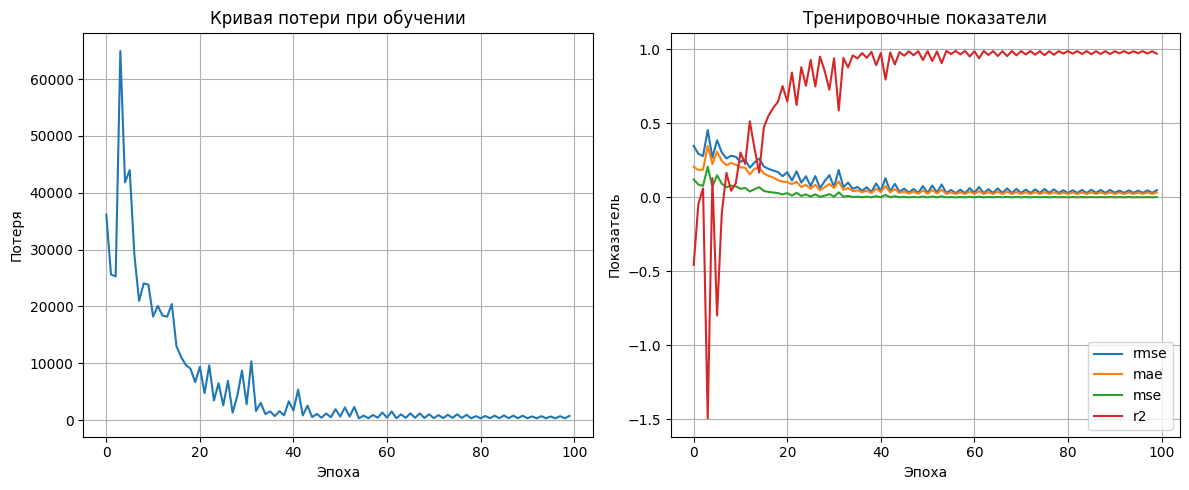

In [35]:
plot_training_history(
    train_results['train_loss'],
    titles=['Кривая потери при обучении', 'Тренировочные показатели'],
    metric_history={
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    },
)

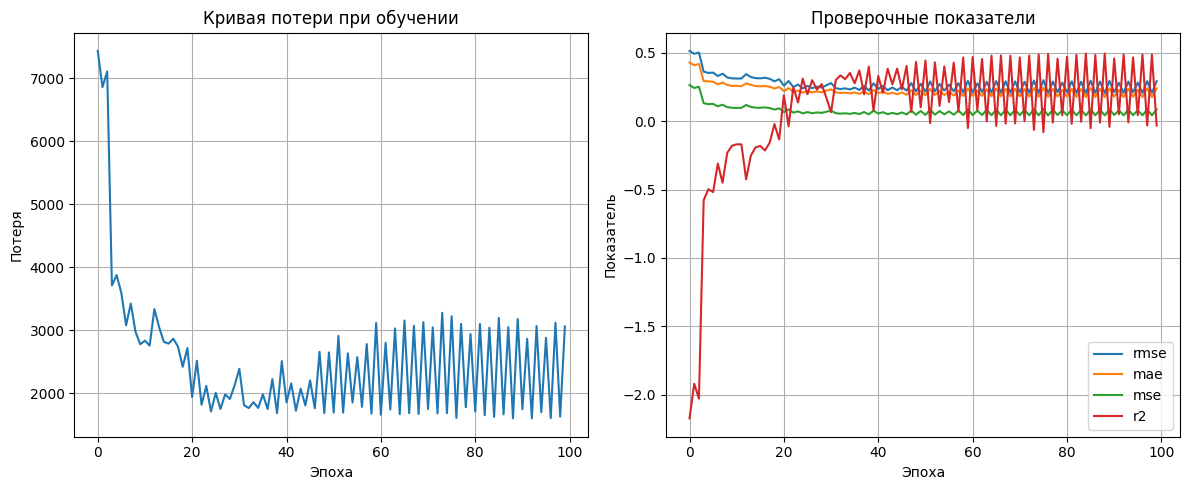

In [36]:
plot_training_history(
    train_results['val_loss'],
    metric_history={
        'rmse': train_results['val_rmse'],
        'mae': train_results['val_mae'],
        'mse': train_results['val_mse'],
        'r2': train_results['val_r2'],
    },
    titles=['Кривая потери при валидации', 'Проверочные показатели'],
)

In [256]:
len(test_loader)

94

In [31]:
# model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data)
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [38]:
# test_results = test(model, test_loader, device)

# test_results

In [39]:
# plot_predictions_vs_actuals(
#     test_results['test_targets'],
#     test_results['test_preds']
# )

In [40]:
# test_results['test_targets'], test_results['test_preds']

In [ ]:
def get_test_results(condition):
    y_true_list = []
    y_pred_list = []
    titles = []
    test_results_list = []

    for bearing in TEST_BEARINGS[condition]:
        titles.append(f"Прогнозирование на Bearing" + bearing)

        test_dataset = BearingDataset(
            df=df[1][df[1]['unit'] == bearing],
        )

        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

        test_results = test(model, test_loader, device)
        y_true_list.append(test_results['test_targets'])
        y_pred_list.append(test_results['test_preds'])
        test_results_list.append({
            'test_r2': test_results['test_r2'],
            'test_mae': test_results['test_mae'],
            'test_mse': test_results['test_mse'],
            'test_rmse': test_results['test_rmse'],
        })
    
    return {
        'y_true_list': y_true_list,
        'y_pred_list': y_pred_list,
        'titles': titles,
        'test_results_list': test_results_list
    }

test_results = get_test_results(condition=1)

plot_predictions_grid(
    y_true_list=test_results['y_true_list'],
    y_pred_list=test_results['y_pred_list'],
    titles=test_results['titles'],
# )

In [42]:
test_results['test_results_list']

[{'test_r2': [0.6178968522949921],
  'test_mae': [0.11782971],
  'test_mse': [0.018312015],
  'test_rmse': [0.13532189]},
 {'test_r2': [0.27566771671978474],
  'test_mae': [0.17726554],
  'test_mse': [0.056832023],
  'test_rmse': [0.23839468]},
 {'test_r2': [0.3287322459410894],
  'test_mae': [0.1643177],
  'test_mse': [0.048826344],
  'test_rmse': [0.22096685]},
 {'test_r2': [0.4767517683657986],
  'test_mae': [0.1620546],
  'test_mse': [0.03852764],
  'test_rmse': [0.19628459]},
 {'test_r2': [0.8648335200181001],
  'test_mae': [0.056690916],
  'test_mse': [0.004973419],
  'test_rmse': [0.07052247]}]

### Condition 2

In [135]:
train_dataset = BearingDataset(
    df=df[0][df[0]['unit'].isin(['2_1'])],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '2_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [136]:
len(train_dataset), len(val_dataset)

(1820, 1592)

In [149]:
model = BearingCNN()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
# criterion = hybrid_r2_mse_loss(alpha=0.2)
criterion = hybrid_r2_mse_loss(0.4)

In [150]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 100)

train_results

100%|██████████| 57/57 [00:00<00:00, 229.50it/s]


Epoch 1: Train Loss 6146.2267, Train R2 = -2.161, Train RMSE = 0.513, Train MSE = 0.263, Train MAE = 0.419


Epoch 1 Val: 100%|██████████| 50/50 [00:00<00:00, 545.90it/s]


Epoch 1: Val Loss 3436.4050, Val R2 = -1.302, Val RMSE = 0.438, Val MSE = 0.191, Val MAE = 0.350


100%|██████████| 57/57 [00:00<00:00, 280.86it/s]


Epoch 2: Train Loss 4228.3083, Train R2 = -1.144, Train RMSE = 0.422, Train MSE = 0.178, Train MAE = 0.347


Epoch 2 Val: 100%|██████████| 50/50 [00:00<00:00, 516.06it/s]


Epoch 2: Val Loss 2538.4956, Val R2 = -0.643, Val RMSE = 0.370, Val MSE = 0.137, Val MAE = 0.298


100%|██████████| 57/57 [00:00<00:00, 215.90it/s]


Epoch 3: Train Loss 3258.9277, Train R2 = -0.637, Train RMSE = 0.369, Train MSE = 0.136, Train MAE = 0.309


Epoch 3 Val: 100%|██████████| 50/50 [00:00<00:00, 499.94it/s]


Epoch 3: Val Loss 2341.2044, Val R2 = -0.494, Val RMSE = 0.352, Val MSE = 0.124, Val MAE = 0.294


100%|██████████| 57/57 [00:00<00:00, 231.54it/s]


Epoch 4: Train Loss 2963.5811, Train R2 = -0.484, Train RMSE = 0.351, Train MSE = 0.123, Train MAE = 0.296


Epoch 4 Val: 100%|██████████| 50/50 [00:00<00:00, 492.03it/s]


Epoch 4: Val Loss 2259.6258, Val R2 = -0.435, Val RMSE = 0.345, Val MSE = 0.119, Val MAE = 0.291


100%|██████████| 57/57 [00:00<00:00, 276.67it/s]


Epoch 5: Train Loss 2830.1927, Train R2 = -0.415, Train RMSE = 0.343, Train MSE = 0.118, Train MAE = 0.290


Epoch 5 Val: 100%|██████████| 50/50 [00:00<00:00, 567.67it/s]


Epoch 5: Val Loss 2184.5359, Val R2 = -0.383, Val RMSE = 0.339, Val MSE = 0.115, Val MAE = 0.288


100%|██████████| 57/57 [00:00<00:00, 252.07it/s]


Epoch 6: Train Loss 2738.1217, Train R2 = -0.368, Train RMSE = 0.337, Train MSE = 0.114, Train MAE = 0.286


Epoch 6 Val: 100%|██████████| 50/50 [00:00<00:00, 521.14it/s]


Epoch 6: Val Loss 2124.4318, Val R2 = -0.340, Val RMSE = 0.334, Val MSE = 0.111, Val MAE = 0.285


100%|██████████| 57/57 [00:00<00:00, 268.41it/s]


Epoch 7: Train Loss 2645.3431, Train R2 = -0.322, Train RMSE = 0.332, Train MSE = 0.110, Train MAE = 0.283


Epoch 7 Val: 100%|██████████| 50/50 [00:00<00:00, 510.33it/s]


Epoch 7: Val Loss 2060.2465, Val R2 = -0.298, Val RMSE = 0.329, Val MSE = 0.108, Val MAE = 0.282


100%|██████████| 57/57 [00:00<00:00, 248.65it/s]


Epoch 8: Train Loss 2584.3422, Train R2 = -0.290, Train RMSE = 0.328, Train MSE = 0.107, Train MAE = 0.280


Epoch 8 Val: 100%|██████████| 50/50 [00:00<00:00, 552.36it/s]


Epoch 8: Val Loss 2003.4154, Val R2 = -0.258, Val RMSE = 0.323, Val MSE = 0.105, Val MAE = 0.279


100%|██████████| 57/57 [00:00<00:00, 245.69it/s]


Epoch 9: Train Loss 2501.3176, Train R2 = -0.249, Train RMSE = 0.322, Train MSE = 0.104, Train MAE = 0.277


Epoch 9 Val: 100%|██████████| 50/50 [00:00<00:00, 527.08it/s]


Epoch 9: Val Loss 1944.2014, Val R2 = -0.220, Val RMSE = 0.318, Val MSE = 0.101, Val MAE = 0.275


100%|██████████| 57/57 [00:00<00:00, 240.24it/s]


Epoch 10: Train Loss 2433.8348, Train R2 = -0.215, Train RMSE = 0.318, Train MSE = 0.101, Train MAE = 0.274


Epoch 10 Val: 100%|██████████| 50/50 [00:00<00:00, 446.10it/s]


Epoch 10: Val Loss 1886.3872, Val R2 = -0.181, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.272


100%|██████████| 57/57 [00:00<00:00, 255.13it/s]


Epoch 11: Train Loss 2360.5714, Train R2 = -0.179, Train RMSE = 0.313, Train MSE = 0.098, Train MAE = 0.271


Epoch 11 Val: 100%|██████████| 50/50 [00:00<00:00, 533.97it/s]


Epoch 11: Val Loss 1818.8455, Val R2 = -0.138, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.267


100%|██████████| 57/57 [00:00<00:00, 258.46it/s]


Epoch 12: Train Loss 2291.8172, Train R2 = -0.144, Train RMSE = 0.309, Train MSE = 0.095, Train MAE = 0.268


Epoch 12 Val: 100%|██████████| 50/50 [00:00<00:00, 538.16it/s]


Epoch 12: Val Loss 1758.3944, Val R2 = -0.098, Val RMSE = 0.302, Val MSE = 0.091, Val MAE = 0.263


100%|██████████| 57/57 [00:00<00:00, 245.43it/s]


Epoch 13: Train Loss 2213.0364, Train R2 = -0.106, Train RMSE = 0.303, Train MSE = 0.092, Train MAE = 0.265


Epoch 13 Val: 100%|██████████| 50/50 [00:00<00:00, 535.08it/s]


Epoch 13: Val Loss 1690.9559, Val R2 = -0.056, Val RMSE = 0.296, Val MSE = 0.088, Val MAE = 0.259


100%|██████████| 57/57 [00:00<00:00, 252.78it/s]


Epoch 14: Train Loss 2149.8522, Train R2 = -0.075, Train RMSE = 0.299, Train MSE = 0.089, Train MAE = 0.262


Epoch 14 Val: 100%|██████████| 50/50 [00:00<00:00, 509.59it/s]


Epoch 14: Val Loss 1617.3207, Val R2 = -0.009, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.253


100%|██████████| 57/57 [00:00<00:00, 241.79it/s]


Epoch 15: Train Loss 2065.7473, Train R2 = -0.034, Train RMSE = 0.293, Train MSE = 0.086, Train MAE = 0.258


Epoch 15 Val: 100%|██████████| 50/50 [00:00<00:00, 462.20it/s]


Epoch 15: Val Loss 1546.0750, Val R2 = 0.035, Val RMSE = 0.283, Val MSE = 0.080, Val MAE = 0.248


100%|██████████| 57/57 [00:00<00:00, 243.21it/s]


Epoch 16: Train Loss 1995.6712, Train R2 = 0.000, Train RMSE = 0.288, Train MSE = 0.083, Train MAE = 0.255


Epoch 16 Val: 100%|██████████| 50/50 [00:00<00:00, 516.98it/s]


Epoch 16: Val Loss 1458.8816, Val R2 = 0.090, Val RMSE = 0.275, Val MSE = 0.076, Val MAE = 0.241


100%|██████████| 57/57 [00:00<00:00, 258.42it/s]


Epoch 17: Train Loss 1918.1846, Train R2 = 0.038, Train RMSE = 0.283, Train MSE = 0.080, Train MAE = 0.251


Epoch 17 Val: 100%|██████████| 50/50 [00:00<00:00, 552.43it/s]


Epoch 17: Val Loss 1379.1906, Val R2 = 0.139, Val RMSE = 0.268, Val MSE = 0.072, Val MAE = 0.234


100%|██████████| 57/57 [00:00<00:00, 255.01it/s]


Epoch 18: Train Loss 1840.8749, Train R2 = 0.075, Train RMSE = 0.277, Train MSE = 0.077, Train MAE = 0.248


Epoch 18 Val: 100%|██████████| 50/50 [00:00<00:00, 535.02it/s]


Epoch 18: Val Loss 1299.9097, Val R2 = 0.187, Val RMSE = 0.260, Val MSE = 0.068, Val MAE = 0.228


100%|██████████| 57/57 [00:00<00:00, 265.57it/s]


Epoch 19: Train Loss 1769.2007, Train R2 = 0.109, Train RMSE = 0.272, Train MSE = 0.074, Train MAE = 0.244


Epoch 19 Val: 100%|██████████| 50/50 [00:00<00:00, 508.48it/s]


Epoch 19: Val Loss 1210.0879, Val R2 = 0.241, Val RMSE = 0.251, Val MSE = 0.063, Val MAE = 0.221


100%|██████████| 57/57 [00:00<00:00, 245.74it/s]


Epoch 20: Train Loss 1714.0633, Train R2 = 0.135, Train RMSE = 0.268, Train MSE = 0.072, Train MAE = 0.241


Epoch 20 Val: 100%|██████████| 50/50 [00:00<00:00, 533.85it/s]


Epoch 20: Val Loss 1141.8083, Val R2 = 0.283, Val RMSE = 0.244, Val MSE = 0.060, Val MAE = 0.215


100%|██████████| 57/57 [00:00<00:00, 268.16it/s]


Epoch 21: Train Loss 1632.2114, Train R2 = 0.175, Train RMSE = 0.262, Train MSE = 0.069, Train MAE = 0.236


Epoch 21 Val: 100%|██████████| 50/50 [00:00<00:00, 538.90it/s]


Epoch 21: Val Loss 1062.2170, Val R2 = 0.330, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.208


100%|██████████| 57/57 [00:00<00:00, 252.39it/s]


Epoch 22: Train Loss 1576.6110, Train R2 = 0.201, Train RMSE = 0.258, Train MSE = 0.066, Train MAE = 0.232


Epoch 22 Val: 100%|██████████| 50/50 [00:00<00:00, 518.21it/s]


Epoch 22: Val Loss 999.6875, Val R2 = 0.367, Val RMSE = 0.229, Val MSE = 0.053, Val MAE = 0.202


100%|██████████| 57/57 [00:00<00:00, 243.45it/s]


Epoch 23: Train Loss 1515.9868, Train R2 = 0.230, Train RMSE = 0.253, Train MSE = 0.064, Train MAE = 0.228


Epoch 23 Val: 100%|██████████| 50/50 [00:00<00:00, 525.56it/s]


Epoch 23: Val Loss 927.1013, Val R2 = 0.409, Val RMSE = 0.222, Val MSE = 0.049, Val MAE = 0.196


100%|██████████| 57/57 [00:00<00:00, 244.13it/s]


Epoch 24: Train Loss 1478.4313, Train R2 = 0.248, Train RMSE = 0.250, Train MSE = 0.063, Train MAE = 0.224


Epoch 24 Val: 100%|██████████| 50/50 [00:00<00:00, 527.28it/s]


Epoch 24: Val Loss 888.8717, Val R2 = 0.432, Val RMSE = 0.217, Val MSE = 0.047, Val MAE = 0.191


100%|██████████| 57/57 [00:00<00:00, 249.06it/s]


Epoch 25: Train Loss 1425.5320, Train R2 = 0.273, Train RMSE = 0.246, Train MSE = 0.060, Train MAE = 0.220


Epoch 25 Val: 100%|██████████| 50/50 [00:00<00:00, 415.76it/s]


Epoch 25: Val Loss 833.1513, Val R2 = 0.464, Val RMSE = 0.211, Val MSE = 0.045, Val MAE = 0.186


100%|██████████| 57/57 [00:00<00:00, 239.72it/s]


Epoch 26: Train Loss 1399.4362, Train R2 = 0.286, Train RMSE = 0.244, Train MSE = 0.059, Train MAE = 0.216


Epoch 26 Val: 100%|██████████| 50/50 [00:00<00:00, 491.88it/s]


Epoch 26: Val Loss 803.7778, Val R2 = 0.481, Val RMSE = 0.208, Val MSE = 0.043, Val MAE = 0.181


100%|██████████| 57/57 [00:00<00:00, 253.48it/s]


Epoch 27: Train Loss 1363.7510, Train R2 = 0.303, Train RMSE = 0.241, Train MSE = 0.058, Train MAE = 0.212


Epoch 27 Val: 100%|██████████| 50/50 [00:00<00:00, 518.79it/s]


Epoch 27: Val Loss 768.9763, Val R2 = 0.501, Val RMSE = 0.204, Val MSE = 0.041, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 244.87it/s]


Epoch 28: Train Loss 1342.5954, Train R2 = 0.313, Train RMSE = 0.239, Train MSE = 0.057, Train MAE = 0.208


Epoch 28 Val: 100%|██████████| 50/50 [00:00<00:00, 510.17it/s]


Epoch 28: Val Loss 749.0774, Val R2 = 0.512, Val RMSE = 0.201, Val MSE = 0.041, Val MAE = 0.173


100%|██████████| 57/57 [00:00<00:00, 251.30it/s]


Epoch 29: Train Loss 1317.0988, Train R2 = 0.325, Train RMSE = 0.237, Train MSE = 0.056, Train MAE = 0.205


Epoch 29 Val: 100%|██████████| 50/50 [00:00<00:00, 548.79it/s]


Epoch 29: Val Loss 729.0092, Val R2 = 0.523, Val RMSE = 0.199, Val MSE = 0.040, Val MAE = 0.170


100%|██████████| 57/57 [00:00<00:00, 257.37it/s]


Epoch 30: Train Loss 1298.9087, Train R2 = 0.334, Train RMSE = 0.235, Train MSE = 0.055, Train MAE = 0.202


Epoch 30 Val: 100%|██████████| 50/50 [00:00<00:00, 437.49it/s]


Epoch 30: Val Loss 713.9660, Val R2 = 0.531, Val RMSE = 0.197, Val MSE = 0.039, Val MAE = 0.167


100%|██████████| 57/57 [00:00<00:00, 236.62it/s]


Epoch 31: Train Loss 1284.9800, Train R2 = 0.340, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.199


Epoch 31 Val: 100%|██████████| 50/50 [00:00<00:00, 516.69it/s]


Epoch 31: Val Loss 700.8934, Val R2 = 0.538, Val RMSE = 0.196, Val MSE = 0.038, Val MAE = 0.166


100%|██████████| 57/57 [00:00<00:00, 249.51it/s]


Epoch 32: Train Loss 1268.5805, Train R2 = 0.348, Train RMSE = 0.233, Train MSE = 0.054, Train MAE = 0.196


Epoch 32 Val: 100%|██████████| 50/50 [00:00<00:00, 523.74it/s]


Epoch 32: Val Loss 689.0811, Val R2 = 0.544, Val RMSE = 0.195, Val MSE = 0.038, Val MAE = 0.164


100%|██████████| 57/57 [00:00<00:00, 240.63it/s]


Epoch 33: Train Loss 1259.4117, Train R2 = 0.352, Train RMSE = 0.232, Train MSE = 0.054, Train MAE = 0.194


Epoch 33 Val: 100%|██████████| 50/50 [00:00<00:00, 513.48it/s]


Epoch 33: Val Loss 677.2738, Val R2 = 0.550, Val RMSE = 0.193, Val MSE = 0.037, Val MAE = 0.162


100%|██████████| 57/57 [00:00<00:00, 257.87it/s]


Epoch 34: Train Loss 1244.2691, Train R2 = 0.360, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.192


Epoch 34 Val: 100%|██████████| 50/50 [00:00<00:00, 473.74it/s]


Epoch 34: Val Loss 668.4257, Val R2 = 0.554, Val RMSE = 0.192, Val MSE = 0.037, Val MAE = 0.161


100%|██████████| 57/57 [00:00<00:00, 258.26it/s]


Epoch 35: Train Loss 1233.6708, Train R2 = 0.365, Train RMSE = 0.230, Train MSE = 0.053, Train MAE = 0.191


Epoch 35 Val: 100%|██████████| 50/50 [00:00<00:00, 514.90it/s]


Epoch 35: Val Loss 661.0235, Val R2 = 0.558, Val RMSE = 0.192, Val MSE = 0.037, Val MAE = 0.161


100%|██████████| 57/57 [00:00<00:00, 240.16it/s]


Epoch 36: Train Loss 1220.3283, Train R2 = 0.372, Train RMSE = 0.229, Train MSE = 0.052, Train MAE = 0.189


Epoch 36 Val: 100%|██████████| 50/50 [00:00<00:00, 517.13it/s]


Epoch 36: Val Loss 655.9770, Val R2 = 0.560, Val RMSE = 0.191, Val MSE = 0.037, Val MAE = 0.160


100%|██████████| 57/57 [00:00<00:00, 236.17it/s]


Epoch 37: Train Loss 1215.6092, Train R2 = 0.374, Train RMSE = 0.228, Train MSE = 0.052, Train MAE = 0.189


Epoch 37 Val: 100%|██████████| 50/50 [00:00<00:00, 504.12it/s]


Epoch 37: Val Loss 653.6749, Val R2 = 0.561, Val RMSE = 0.191, Val MSE = 0.036, Val MAE = 0.160


100%|██████████| 57/57 [00:00<00:00, 246.74it/s]


Epoch 38: Train Loss 1199.8142, Train R2 = 0.382, Train RMSE = 0.227, Train MSE = 0.051, Train MAE = 0.187


Epoch 38 Val: 100%|██████████| 50/50 [00:00<00:00, 507.66it/s]


Epoch 38: Val Loss 650.8525, Val R2 = 0.563, Val RMSE = 0.191, Val MSE = 0.036, Val MAE = 0.160


100%|██████████| 57/57 [00:00<00:00, 252.31it/s]


Epoch 39: Train Loss 1193.6053, Train R2 = 0.385, Train RMSE = 0.226, Train MSE = 0.051, Train MAE = 0.187


Epoch 39 Val: 100%|██████████| 50/50 [00:00<00:00, 502.36it/s]


Epoch 39: Val Loss 649.7062, Val R2 = 0.563, Val RMSE = 0.191, Val MSE = 0.036, Val MAE = 0.160


100%|██████████| 57/57 [00:00<00:00, 241.10it/s]


Epoch 40: Train Loss 1182.1110, Train R2 = 0.391, Train RMSE = 0.225, Train MSE = 0.051, Train MAE = 0.186


Epoch 40 Val: 100%|██████████| 50/50 [00:00<00:00, 519.60it/s]


Epoch 40: Val Loss 647.8501, Val R2 = 0.564, Val RMSE = 0.190, Val MSE = 0.036, Val MAE = 0.160


100%|██████████| 57/57 [00:00<00:00, 253.50it/s]


Epoch 41: Train Loss 1179.1339, Train R2 = 0.392, Train RMSE = 0.225, Train MSE = 0.051, Train MAE = 0.186


Epoch 41 Val: 100%|██████████| 50/50 [00:00<00:00, 525.45it/s]


Epoch 41: Val Loss 649.6013, Val R2 = 0.563, Val RMSE = 0.191, Val MSE = 0.036, Val MAE = 0.160


100%|██████████| 57/57 [00:00<00:00, 256.24it/s]


Epoch 42: Train Loss 1168.3000, Train R2 = 0.398, Train RMSE = 0.224, Train MSE = 0.050, Train MAE = 0.185


Epoch 42 Val: 100%|██████████| 50/50 [00:00<00:00, 539.00it/s]


Epoch 42: Val Loss 649.6650, Val R2 = 0.562, Val RMSE = 0.191, Val MSE = 0.036, Val MAE = 0.160


100%|██████████| 57/57 [00:00<00:00, 236.09it/s]


Epoch 43: Train Loss 1163.3113, Train R2 = 0.400, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.184


Epoch 43 Val: 100%|██████████| 50/50 [00:00<00:00, 513.77it/s]


Epoch 43: Val Loss 652.4921, Val R2 = 0.560, Val RMSE = 0.191, Val MSE = 0.037, Val MAE = 0.161


100%|██████████| 57/57 [00:00<00:00, 244.83it/s]


Epoch 44: Train Loss 1157.7543, Train R2 = 0.403, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.184


Epoch 44 Val: 100%|██████████| 50/50 [00:00<00:00, 500.59it/s]


Epoch 44: Val Loss 655.0630, Val R2 = 0.559, Val RMSE = 0.192, Val MSE = 0.037, Val MAE = 0.161


100%|██████████| 57/57 [00:00<00:00, 218.61it/s]


Epoch 45: Train Loss 1151.0651, Train R2 = 0.407, Train RMSE = 0.222, Train MSE = 0.049, Train MAE = 0.184


Epoch 45 Val: 100%|██████████| 50/50 [00:00<00:00, 518.38it/s]


Epoch 45: Val Loss 656.9016, Val R2 = 0.557, Val RMSE = 0.192, Val MSE = 0.037, Val MAE = 0.161


100%|██████████| 57/57 [00:00<00:00, 232.67it/s]


Epoch 46: Train Loss 1148.3693, Train R2 = 0.408, Train RMSE = 0.222, Train MSE = 0.049, Train MAE = 0.183


Epoch 46 Val: 100%|██████████| 50/50 [00:00<00:00, 524.49it/s]


Epoch 46: Val Loss 663.1891, Val R2 = 0.553, Val RMSE = 0.193, Val MSE = 0.037, Val MAE = 0.162


100%|██████████| 57/57 [00:00<00:00, 226.67it/s]


Epoch 47: Train Loss 1139.8604, Train R2 = 0.412, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.183


Epoch 47 Val: 100%|██████████| 50/50 [00:00<00:00, 493.32it/s]


Epoch 47: Val Loss 666.2961, Val R2 = 0.551, Val RMSE = 0.193, Val MSE = 0.037, Val MAE = 0.162


100%|██████████| 57/57 [00:00<00:00, 252.50it/s]


Epoch 48: Train Loss 1139.8931, Train R2 = 0.412, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.183


Epoch 48 Val: 100%|██████████| 50/50 [00:00<00:00, 544.21it/s]


Epoch 48: Val Loss 675.1142, Val R2 = 0.546, Val RMSE = 0.194, Val MSE = 0.038, Val MAE = 0.163


100%|██████████| 57/57 [00:00<00:00, 240.66it/s]


Epoch 49: Train Loss 1129.8424, Train R2 = 0.418, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.182


Epoch 49 Val: 100%|██████████| 50/50 [00:00<00:00, 509.29it/s]


Epoch 49: Val Loss 678.3790, Val R2 = 0.544, Val RMSE = 0.195, Val MSE = 0.038, Val MAE = 0.164


100%|██████████| 57/57 [00:00<00:00, 243.55it/s]


Epoch 50: Train Loss 1129.9432, Train R2 = 0.417, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.182


Epoch 50 Val: 100%|██████████| 50/50 [00:00<00:00, 499.36it/s]


Epoch 50: Val Loss 689.6581, Val R2 = 0.536, Val RMSE = 0.196, Val MSE = 0.039, Val MAE = 0.165


100%|██████████| 57/57 [00:00<00:00, 234.49it/s]


Epoch 51: Train Loss 1121.4966, Train R2 = 0.422, Train RMSE = 0.219, Train MSE = 0.048, Train MAE = 0.182


Epoch 51 Val: 100%|██████████| 50/50 [00:00<00:00, 509.80it/s]


Epoch 51: Val Loss 692.8785, Val R2 = 0.534, Val RMSE = 0.197, Val MSE = 0.039, Val MAE = 0.165


100%|██████████| 57/57 [00:00<00:00, 245.81it/s]


Epoch 52: Train Loss 1121.2496, Train R2 = 0.422, Train RMSE = 0.219, Train MSE = 0.048, Train MAE = 0.182


Epoch 52 Val: 100%|██████████| 50/50 [00:00<00:00, 440.06it/s]


Epoch 52: Val Loss 707.4343, Val R2 = 0.525, Val RMSE = 0.199, Val MSE = 0.040, Val MAE = 0.166


100%|██████████| 57/57 [00:00<00:00, 229.48it/s]


Epoch 53: Train Loss 1112.0797, Train R2 = 0.427, Train RMSE = 0.218, Train MSE = 0.048, Train MAE = 0.181


Epoch 53 Val: 100%|██████████| 50/50 [00:00<00:00, 445.43it/s]


Epoch 53: Val Loss 710.0184, Val R2 = 0.523, Val RMSE = 0.199, Val MSE = 0.040, Val MAE = 0.166


100%|██████████| 57/57 [00:00<00:00, 239.22it/s]


Epoch 54: Train Loss 1112.4010, Train R2 = 0.427, Train RMSE = 0.218, Train MSE = 0.048, Train MAE = 0.181


Epoch 54 Val: 100%|██████████| 50/50 [00:00<00:00, 507.28it/s]


Epoch 54: Val Loss 726.0297, Val R2 = 0.513, Val RMSE = 0.201, Val MSE = 0.041, Val MAE = 0.168


100%|██████████| 57/57 [00:00<00:00, 244.21it/s]


Epoch 55: Train Loss 1104.7777, Train R2 = 0.430, Train RMSE = 0.218, Train MSE = 0.047, Train MAE = 0.181


Epoch 55 Val: 100%|██████████| 50/50 [00:00<00:00, 505.78it/s]


Epoch 55: Val Loss 732.7379, Val R2 = 0.508, Val RMSE = 0.202, Val MSE = 0.041, Val MAE = 0.168


100%|██████████| 57/57 [00:00<00:00, 243.34it/s]


Epoch 56: Train Loss 1103.3971, Train R2 = 0.431, Train RMSE = 0.218, Train MSE = 0.047, Train MAE = 0.181


Epoch 56 Val: 100%|██████████| 50/50 [00:00<00:00, 506.26it/s]


Epoch 56: Val Loss 745.2700, Val R2 = 0.500, Val RMSE = 0.204, Val MSE = 0.042, Val MAE = 0.169


100%|██████████| 57/57 [00:00<00:00, 237.45it/s]


Epoch 57: Train Loss 1097.2351, Train R2 = 0.434, Train RMSE = 0.217, Train MSE = 0.047, Train MAE = 0.180


Epoch 57 Val: 100%|██████████| 50/50 [00:00<00:00, 459.12it/s]


Epoch 57: Val Loss 758.4002, Val R2 = 0.492, Val RMSE = 0.206, Val MSE = 0.042, Val MAE = 0.170


100%|██████████| 57/57 [00:00<00:00, 242.42it/s]


Epoch 58: Train Loss 1094.0079, Train R2 = 0.436, Train RMSE = 0.217, Train MSE = 0.047, Train MAE = 0.180


Epoch 58 Val: 100%|██████████| 50/50 [00:00<00:00, 504.33it/s]


Epoch 58: Val Loss 770.8611, Val R2 = 0.484, Val RMSE = 0.207, Val MSE = 0.043, Val MAE = 0.171


100%|██████████| 57/57 [00:00<00:00, 236.63it/s]


Epoch 59: Train Loss 1089.5329, Train R2 = 0.438, Train RMSE = 0.216, Train MSE = 0.047, Train MAE = 0.180


Epoch 59 Val: 100%|██████████| 50/50 [00:00<00:00, 515.95it/s]


Epoch 59: Val Loss 785.5293, Val R2 = 0.474, Val RMSE = 0.209, Val MSE = 0.044, Val MAE = 0.172


100%|██████████| 57/57 [00:00<00:00, 223.78it/s]


Epoch 60: Train Loss 1085.6015, Train R2 = 0.440, Train RMSE = 0.216, Train MSE = 0.047, Train MAE = 0.179


Epoch 60 Val: 100%|██████████| 50/50 [00:00<00:00, 500.14it/s]


Epoch 60: Val Loss 801.2247, Val R2 = 0.464, Val RMSE = 0.211, Val MSE = 0.045, Val MAE = 0.173


100%|██████████| 57/57 [00:00<00:00, 242.52it/s]


Epoch 61: Train Loss 1081.4526, Train R2 = 0.443, Train RMSE = 0.215, Train MSE = 0.046, Train MAE = 0.179


Epoch 61 Val: 100%|██████████| 50/50 [00:00<00:00, 488.34it/s]


Epoch 61: Val Loss 819.5032, Val R2 = 0.452, Val RMSE = 0.213, Val MSE = 0.046, Val MAE = 0.175


100%|██████████| 57/57 [00:00<00:00, 233.76it/s]


Epoch 62: Train Loss 1077.6209, Train R2 = 0.444, Train RMSE = 0.215, Train MSE = 0.046, Train MAE = 0.179


Epoch 62 Val: 100%|██████████| 50/50 [00:00<00:00, 526.55it/s]


Epoch 62: Val Loss 829.1655, Val R2 = 0.446, Val RMSE = 0.215, Val MSE = 0.046, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 247.30it/s]


Epoch 63: Train Loss 1074.1800, Train R2 = 0.446, Train RMSE = 0.215, Train MSE = 0.046, Train MAE = 0.179


Epoch 63 Val: 100%|██████████| 50/50 [00:00<00:00, 467.72it/s]


Epoch 63: Val Loss 852.5593, Val R2 = 0.431, Val RMSE = 0.218, Val MSE = 0.047, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 229.97it/s]


Epoch 64: Train Loss 1069.2223, Train R2 = 0.449, Train RMSE = 0.214, Train MSE = 0.046, Train MAE = 0.178


Epoch 64 Val: 100%|██████████| 50/50 [00:00<00:00, 527.86it/s]


Epoch 64: Val Loss 866.4832, Val R2 = 0.421, Val RMSE = 0.219, Val MSE = 0.048, Val MAE = 0.178


100%|██████████| 57/57 [00:00<00:00, 242.13it/s]


Epoch 65: Train Loss 1065.9952, Train R2 = 0.450, Train RMSE = 0.214, Train MSE = 0.046, Train MAE = 0.178


Epoch 65 Val: 100%|██████████| 50/50 [00:00<00:00, 446.37it/s]


Epoch 65: Val Loss 889.9908, Val R2 = 0.406, Val RMSE = 0.222, Val MSE = 0.049, Val MAE = 0.180


100%|██████████| 57/57 [00:00<00:00, 242.86it/s]


Epoch 66: Train Loss 1062.4128, Train R2 = 0.452, Train RMSE = 0.213, Train MSE = 0.046, Train MAE = 0.178


Epoch 66 Val: 100%|██████████| 50/50 [00:00<00:00, 441.93it/s]


Epoch 66: Val Loss 907.7137, Val R2 = 0.395, Val RMSE = 0.224, Val MSE = 0.050, Val MAE = 0.181


100%|██████████| 57/57 [00:00<00:00, 242.93it/s]


Epoch 67: Train Loss 1058.2195, Train R2 = 0.454, Train RMSE = 0.213, Train MSE = 0.045, Train MAE = 0.178


Epoch 67 Val: 100%|██████████| 50/50 [00:00<00:00, 396.33it/s]


Epoch 67: Val Loss 927.0980, Val R2 = 0.382, Val RMSE = 0.227, Val MSE = 0.051, Val MAE = 0.182


100%|██████████| 57/57 [00:00<00:00, 234.72it/s]


Epoch 68: Train Loss 1054.2898, Train R2 = 0.456, Train RMSE = 0.213, Train MSE = 0.045, Train MAE = 0.177


Epoch 68 Val: 100%|██████████| 50/50 [00:00<00:00, 509.09it/s]


Epoch 68: Val Loss 950.7257, Val R2 = 0.366, Val RMSE = 0.230, Val MSE = 0.053, Val MAE = 0.184


100%|██████████| 57/57 [00:00<00:00, 242.24it/s]


Epoch 69: Train Loss 1049.7282, Train R2 = 0.459, Train RMSE = 0.212, Train MSE = 0.045, Train MAE = 0.177


Epoch 69 Val: 100%|██████████| 50/50 [00:00<00:00, 530.54it/s]


Epoch 69: Val Loss 974.9533, Val R2 = 0.351, Val RMSE = 0.232, Val MSE = 0.054, Val MAE = 0.186


100%|██████████| 57/57 [00:00<00:00, 245.81it/s]


Epoch 70: Train Loss 1045.9954, Train R2 = 0.461, Train RMSE = 0.212, Train MSE = 0.045, Train MAE = 0.177


Epoch 70 Val: 100%|██████████| 50/50 [00:00<00:00, 500.63it/s]


Epoch 70: Val Loss 993.0438, Val R2 = 0.339, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.187


100%|██████████| 57/57 [00:00<00:00, 240.71it/s]


Epoch 71: Train Loss 1040.6821, Train R2 = 0.464, Train RMSE = 0.211, Train MSE = 0.045, Train MAE = 0.177


Epoch 71 Val: 100%|██████████| 50/50 [00:00<00:00, 446.40it/s]


Epoch 71: Val Loss 1022.7053, Val R2 = 0.319, Val RMSE = 0.238, Val MSE = 0.057, Val MAE = 0.189


100%|██████████| 57/57 [00:00<00:00, 234.45it/s]


Epoch 72: Train Loss 1034.5960, Train R2 = 0.467, Train RMSE = 0.211, Train MSE = 0.044, Train MAE = 0.176


Epoch 72 Val: 100%|██████████| 50/50 [00:00<00:00, 529.09it/s]


Epoch 72: Val Loss 1050.3185, Val R2 = 0.301, Val RMSE = 0.241, Val MSE = 0.058, Val MAE = 0.191


100%|██████████| 57/57 [00:00<00:00, 213.27it/s]


Epoch 73: Train Loss 1031.2489, Train R2 = 0.468, Train RMSE = 0.210, Train MSE = 0.044, Train MAE = 0.176


Epoch 73 Val: 100%|██████████| 50/50 [00:00<00:00, 480.25it/s]


Epoch 73: Val Loss 1079.1987, Val R2 = 0.282, Val RMSE = 0.244, Val MSE = 0.060, Val MAE = 0.193


100%|██████████| 57/57 [00:00<00:00, 237.88it/s]


Epoch 74: Train Loss 1026.6065, Train R2 = 0.471, Train RMSE = 0.210, Train MSE = 0.044, Train MAE = 0.176


Epoch 74 Val: 100%|██████████| 50/50 [00:00<00:00, 452.55it/s]


Epoch 74: Val Loss 1105.5511, Val R2 = 0.265, Val RMSE = 0.247, Val MSE = 0.061, Val MAE = 0.194


100%|██████████| 57/57 [00:00<00:00, 237.27it/s]


Epoch 75: Train Loss 1022.5880, Train R2 = 0.473, Train RMSE = 0.209, Train MSE = 0.044, Train MAE = 0.175


Epoch 75 Val: 100%|██████████| 50/50 [00:00<00:00, 493.50it/s]


Epoch 75: Val Loss 1143.0369, Val R2 = 0.241, Val RMSE = 0.251, Val MSE = 0.063, Val MAE = 0.197


100%|██████████| 57/57 [00:00<00:00, 242.31it/s]


Epoch 76: Train Loss 1020.3372, Train R2 = 0.474, Train RMSE = 0.209, Train MSE = 0.044, Train MAE = 0.175


Epoch 76 Val: 100%|██████████| 50/50 [00:00<00:00, 511.24it/s]


Epoch 76: Val Loss 1166.6082, Val R2 = 0.225, Val RMSE = 0.254, Val MSE = 0.064, Val MAE = 0.198


100%|██████████| 57/57 [00:00<00:00, 233.80it/s]


Epoch 77: Train Loss 1015.0535, Train R2 = 0.477, Train RMSE = 0.209, Train MSE = 0.044, Train MAE = 0.175


Epoch 77 Val: 100%|██████████| 50/50 [00:00<00:00, 510.60it/s]


Epoch 77: Val Loss 1192.9319, Val R2 = 0.208, Val RMSE = 0.257, Val MSE = 0.066, Val MAE = 0.200


100%|██████████| 57/57 [00:00<00:00, 237.39it/s]


Epoch 78: Train Loss 1010.9953, Train R2 = 0.479, Train RMSE = 0.208, Train MSE = 0.043, Train MAE = 0.175


Epoch 78 Val: 100%|██████████| 50/50 [00:00<00:00, 493.43it/s]


Epoch 78: Val Loss 1237.6732, Val R2 = 0.178, Val RMSE = 0.261, Val MSE = 0.068, Val MAE = 0.203


100%|██████████| 57/57 [00:00<00:00, 236.94it/s]


Epoch 79: Train Loss 1005.1503, Train R2 = 0.482, Train RMSE = 0.208, Train MSE = 0.043, Train MAE = 0.174


Epoch 79 Val: 100%|██████████| 50/50 [00:00<00:00, 488.97it/s]


Epoch 79: Val Loss 1260.4306, Val R2 = 0.163, Val RMSE = 0.264, Val MSE = 0.070, Val MAE = 0.204


100%|██████████| 57/57 [00:00<00:00, 226.52it/s]


Epoch 80: Train Loss 1002.6428, Train R2 = 0.483, Train RMSE = 0.207, Train MSE = 0.043, Train MAE = 0.174


Epoch 80 Val: 100%|██████████| 50/50 [00:00<00:00, 516.59it/s]


Epoch 80: Val Loss 1302.0569, Val R2 = 0.136, Val RMSE = 0.268, Val MSE = 0.072, Val MAE = 0.207


100%|██████████| 57/57 [00:00<00:00, 214.48it/s]


Epoch 81: Train Loss 997.3363, Train R2 = 0.486, Train RMSE = 0.207, Train MSE = 0.043, Train MAE = 0.174


Epoch 81 Val: 100%|██████████| 50/50 [00:00<00:00, 511.26it/s]


Epoch 81: Val Loss 1332.2214, Val R2 = 0.116, Val RMSE = 0.271, Val MSE = 0.074, Val MAE = 0.209


100%|██████████| 57/57 [00:00<00:00, 234.18it/s]


Epoch 82: Train Loss 993.3950, Train R2 = 0.488, Train RMSE = 0.206, Train MSE = 0.043, Train MAE = 0.173


Epoch 82 Val: 100%|██████████| 50/50 [00:00<00:00, 493.17it/s]


Epoch 82: Val Loss 1373.8627, Val R2 = 0.089, Val RMSE = 0.275, Val MSE = 0.076, Val MAE = 0.212


100%|██████████| 57/57 [00:00<00:00, 234.35it/s]


Epoch 83: Train Loss 989.1596, Train R2 = 0.490, Train RMSE = 0.206, Train MSE = 0.042, Train MAE = 0.173


Epoch 83 Val: 100%|██████████| 50/50 [00:00<00:00, 446.31it/s]


Epoch 83: Val Loss 1405.2768, Val R2 = 0.068, Val RMSE = 0.278, Val MSE = 0.078, Val MAE = 0.214


100%|██████████| 57/57 [00:00<00:00, 245.01it/s]


Epoch 84: Train Loss 984.8469, Train R2 = 0.492, Train RMSE = 0.205, Train MSE = 0.042, Train MAE = 0.173


Epoch 84 Val: 100%|██████████| 50/50 [00:00<00:00, 502.65it/s]


Epoch 84: Val Loss 1450.6434, Val R2 = 0.038, Val RMSE = 0.283, Val MSE = 0.080, Val MAE = 0.217


100%|██████████| 57/57 [00:00<00:00, 233.54it/s]


Epoch 85: Train Loss 980.4456, Train R2 = 0.495, Train RMSE = 0.205, Train MSE = 0.042, Train MAE = 0.172


Epoch 85 Val: 100%|██████████| 50/50 [00:00<00:00, 515.52it/s]


Epoch 85: Val Loss 1485.6015, Val R2 = 0.015, Val RMSE = 0.286, Val MSE = 0.082, Val MAE = 0.219


100%|██████████| 57/57 [00:00<00:00, 233.57it/s]


Epoch 86: Train Loss 976.2648, Train R2 = 0.497, Train RMSE = 0.205, Train MSE = 0.042, Train MAE = 0.172


Epoch 86 Val: 100%|██████████| 50/50 [00:00<00:00, 523.29it/s]


Epoch 86: Val Loss 1529.3617, Val R2 = -0.014, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.221


100%|██████████| 57/57 [00:00<00:00, 233.62it/s]


Epoch 87: Train Loss 972.2493, Train R2 = 0.499, Train RMSE = 0.204, Train MSE = 0.042, Train MAE = 0.172


Epoch 87 Val: 100%|██████████| 50/50 [00:00<00:00, 456.09it/s]


Epoch 87: Val Loss 1570.2301, Val R2 = -0.041, Val RMSE = 0.294, Val MSE = 0.087, Val MAE = 0.224


100%|██████████| 57/57 [00:00<00:00, 242.28it/s]


Epoch 88: Train Loss 967.6061, Train R2 = 0.501, Train RMSE = 0.204, Train MSE = 0.041, Train MAE = 0.172


Epoch 88 Val: 100%|██████████| 50/50 [00:00<00:00, 409.74it/s]


Epoch 88: Val Loss 1613.5398, Val R2 = -0.070, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.227


100%|██████████| 57/57 [00:00<00:00, 235.61it/s]


Epoch 89: Train Loss 963.7212, Train R2 = 0.503, Train RMSE = 0.203, Train MSE = 0.041, Train MAE = 0.171


Epoch 89 Val: 100%|██████████| 50/50 [00:00<00:00, 520.48it/s]


Epoch 89: Val Loss 1663.0682, Val R2 = -0.102, Val RMSE = 0.303, Val MSE = 0.092, Val MAE = 0.230


100%|██████████| 57/57 [00:00<00:00, 240.97it/s]


Epoch 90: Train Loss 957.9293, Train R2 = 0.506, Train RMSE = 0.203, Train MSE = 0.041, Train MAE = 0.171


Epoch 90 Val: 100%|██████████| 50/50 [00:00<00:00, 516.50it/s]


Epoch 90: Val Loss 1699.9137, Val R2 = -0.127, Val RMSE = 0.306, Val MSE = 0.094, Val MAE = 0.232


100%|██████████| 57/57 [00:00<00:00, 236.60it/s]


Epoch 91: Train Loss 955.4303, Train R2 = 0.507, Train RMSE = 0.202, Train MSE = 0.041, Train MAE = 0.171


Epoch 91 Val: 100%|██████████| 50/50 [00:00<00:00, 516.08it/s]


Epoch 91: Val Loss 1751.0789, Val R2 = -0.160, Val RMSE = 0.311, Val MSE = 0.096, Val MAE = 0.236


100%|██████████| 57/57 [00:00<00:00, 236.90it/s]


Epoch 92: Train Loss 948.9421, Train R2 = 0.511, Train RMSE = 0.202, Train MSE = 0.041, Train MAE = 0.170


Epoch 92 Val: 100%|██████████| 50/50 [00:00<00:00, 523.80it/s]


Epoch 92: Val Loss 1802.6782, Val R2 = -0.195, Val RMSE = 0.315, Val MSE = 0.099, Val MAE = 0.239


100%|██████████| 57/57 [00:00<00:00, 226.96it/s]


Epoch 93: Train Loss 944.4395, Train R2 = 0.513, Train RMSE = 0.201, Train MSE = 0.041, Train MAE = 0.170


Epoch 93 Val: 100%|██████████| 50/50 [00:00<00:00, 434.31it/s]


Epoch 93: Val Loss 1846.5935, Val R2 = -0.224, Val RMSE = 0.319, Val MSE = 0.102, Val MAE = 0.242


100%|██████████| 57/57 [00:00<00:00, 231.79it/s]


Epoch 94: Train Loss 941.0318, Train R2 = 0.515, Train RMSE = 0.201, Train MSE = 0.040, Train MAE = 0.170


Epoch 94 Val: 100%|██████████| 50/50 [00:00<00:00, 493.03it/s]


Epoch 94: Val Loss 1908.6061, Val R2 = -0.264, Val RMSE = 0.324, Val MSE = 0.105, Val MAE = 0.246


100%|██████████| 57/57 [00:00<00:00, 235.02it/s]


Epoch 95: Train Loss 933.9498, Train R2 = 0.518, Train RMSE = 0.200, Train MSE = 0.040, Train MAE = 0.169


Epoch 95 Val: 100%|██████████| 50/50 [00:00<00:00, 520.80it/s]


Epoch 95: Val Loss 1938.4231, Val R2 = -0.285, Val RMSE = 0.327, Val MSE = 0.107, Val MAE = 0.249


100%|██████████| 57/57 [00:00<00:00, 220.65it/s]


Epoch 96: Train Loss 932.9414, Train R2 = 0.519, Train RMSE = 0.200, Train MSE = 0.040, Train MAE = 0.169


Epoch 96 Val: 100%|██████████| 50/50 [00:00<00:00, 513.70it/s]


Epoch 96: Val Loss 2005.4039, Val R2 = -0.329, Val RMSE = 0.332, Val MSE = 0.110, Val MAE = 0.253


100%|██████████| 57/57 [00:00<00:00, 242.80it/s]


Epoch 97: Train Loss 925.6773, Train R2 = 0.523, Train RMSE = 0.199, Train MSE = 0.040, Train MAE = 0.168


Epoch 97 Val: 100%|██████████| 50/50 [00:00<00:00, 506.68it/s]


Epoch 97: Val Loss 2066.2345, Val R2 = -0.369, Val RMSE = 0.337, Val MSE = 0.114, Val MAE = 0.257


100%|██████████| 57/57 [00:00<00:00, 241.42it/s]


Epoch 98: Train Loss 920.2242, Train R2 = 0.525, Train RMSE = 0.199, Train MSE = 0.039, Train MAE = 0.168


Epoch 98 Val: 100%|██████████| 50/50 [00:00<00:00, 455.92it/s]


Epoch 98: Val Loss 2106.2716, Val R2 = -0.396, Val RMSE = 0.341, Val MSE = 0.116, Val MAE = 0.260


100%|██████████| 57/57 [00:00<00:00, 232.33it/s]


Epoch 99: Train Loss 918.4461, Train R2 = 0.526, Train RMSE = 0.198, Train MSE = 0.039, Train MAE = 0.168


Epoch 99 Val: 100%|██████████| 50/50 [00:00<00:00, 486.72it/s]


Epoch 99: Val Loss 2172.8158, Val R2 = -0.439, Val RMSE = 0.346, Val MSE = 0.120, Val MAE = 0.265


100%|██████████| 57/57 [00:00<00:00, 227.74it/s]


Epoch 100: Train Loss 910.7654, Train R2 = 0.530, Train RMSE = 0.198, Train MSE = 0.039, Train MAE = 0.167


Epoch 100 Val: 100%|██████████| 50/50 [00:00<00:00, 514.52it/s]

Epoch 100: Val Loss 2221.7495, Val R2 = -0.472, Val RMSE = 0.350, Val MSE = 0.122, Val MAE = 0.269


{'train_loss': [6146.2266967929245,
  4228.308257847501,
  3258.92765730724,
  2963.5810774962106,
  2830.1927218395367,
  2738.121738728724,
  2645.3431043316396,
  2584.3421559135118,
  2501.317568509725,
  2433.834760179645,
  2360.5714179842093,
  2291.817196009452,
  2213.036373910151,
  2149.8522332111993,
  2065.7473171886645,
  1995.671240139426,
  1918.1846144868616,
  1840.874938276776,
  1769.2007454152692,
  1714.0633141618025,
  1632.211407163687,
  1576.6109746046234,
  1515.9867810199135,
  1478.4312636224847,
  1425.5320083467584,
  1399.4362204869587,
  1363.7509643655073,
  1342.595406197665,
  1317.098778540628,
  1298.908706765426,
  1284.980039036065,
  1268.5805295559398,
  1259.4117351414864,
  1244.2690797563184,
  1233.6707850841053,
  1220.328270343312,
  1215.6092319739491,
  1199.8141597362987,
  1193.6052760241325,
  1182.110976127156,
  1179.1338547405444,
  1168.3000248440526,
  1163.3113072545905,
  1157.7542701771386,
  1151.0650910829243,
  1148.369254

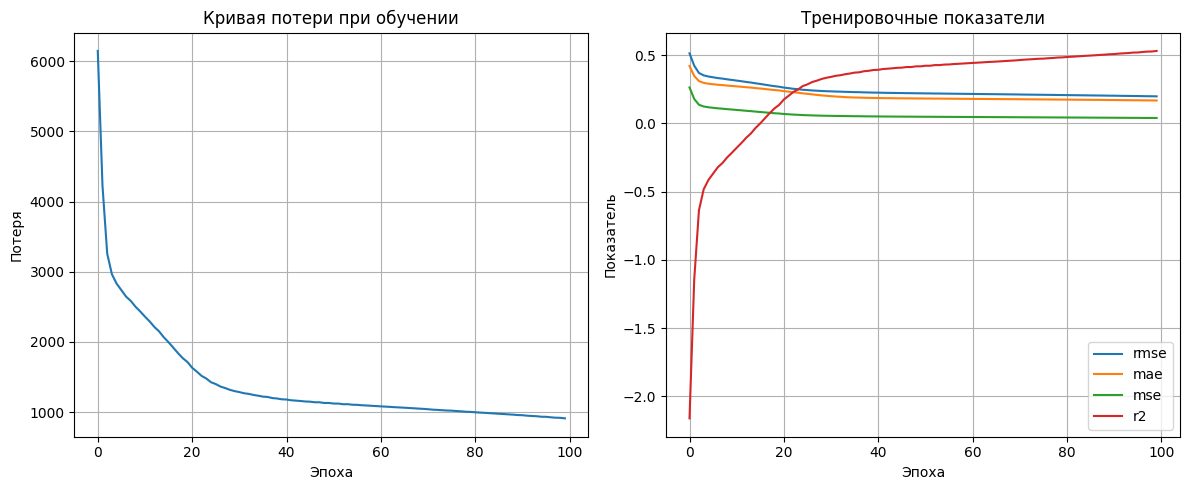

In [151]:
plot_training_history(
    train_results['train_loss'],
    titles=['Кривая потери при обучении', 'Тренировочные показатели'],
    metric_history={
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    },
)

100%|██████████| 11/11 [00:00<00:00, 689.69it/s]


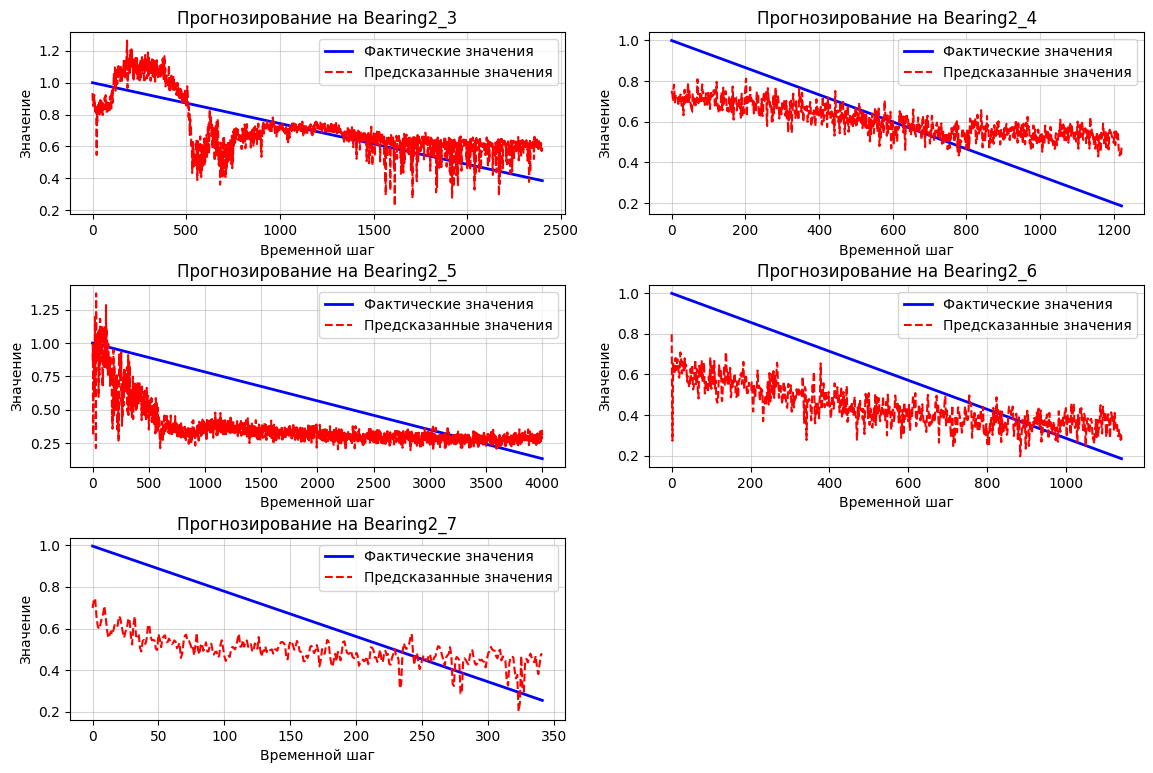

In [152]:
test_results = get_test_results(condition=2)

plot_predictions_grid(
    y_true_list=test_results['y_true_list'],
    y_pred_list=test_results['y_pred_list'],
    titles=test_results['titles'],
)

In [153]:
test_results['test_results_list']

[{'test_r2': [0.3845922100844694],
  'test_mae': [0.110927284],
  'test_mse': [0.019356133],
  'test_rmse': [0.13912632]},
 {'test_r2': [0.4521559833694544],
  'test_mae': [0.14666225],
  'test_mse': [0.0302269],
  'test_rmse': [0.17385885]},
 {'test_r2': [-0.21211032731025825],
  'test_mae': [0.22945912],
  'test_mse': [0.07573432],
  'test_rmse': [0.2751987]},
 {'test_r2': [0.08072917529001877],
  'test_mae': [0.19211647],
  'test_mse': [0.05084193],
  'test_rmse': [0.22548155]},
 {'test_r2': [-0.009061429202162019],
  'test_mae': [0.1824323],
  'test_mse': [0.046520773],
  'test_rmse': [0.21568675]}]

### Condition 3

In [147]:
train_dataset = BearingDataset(
    df=df[0][df[0]['unit'].isin(['3_2'])],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '3_1'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(val_dataset)

model = BearingCNN()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = hybrid_r2_mse_loss(alpha=0.3)

In [148]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 100)

train_results

100%|██████████| 103/103 [00:00<00:00, 234.15it/s]


Epoch 1: Train Loss 13581.0893, Train R2 = -0.717, Train RMSE = 0.378, Train MSE = 0.143, Train MAE = 0.275


Epoch 1 Val: 100%|██████████| 33/33 [00:00<00:00, 426.90it/s]


Epoch 1: Val Loss 2344.7166, Val R2 = -1.599, Val RMSE = 0.465, Val MSE = 0.216, Val MAE = 0.384


100%|██████████| 103/103 [00:00<00:00, 253.70it/s]


Epoch 2: Train Loss 20655.1640, Train R2 = -1.512, Train RMSE = 0.457, Train MSE = 0.209, Train MAE = 0.370


Epoch 2 Val: 100%|██████████| 33/33 [00:00<00:00, 484.99it/s]


Epoch 2: Val Loss 2835.0197, Val R2 = -0.700, Val RMSE = 0.376, Val MSE = 0.141, Val MAE = 0.309


100%|██████████| 103/103 [00:00<00:00, 248.28it/s]


Epoch 3: Train Loss 14542.4223, Train R2 = -0.896, Train RMSE = 0.397, Train MSE = 0.158, Train MAE = 0.326


Epoch 3 Val: 100%|██████████| 33/33 [00:00<00:00, 485.41it/s]


Epoch 3: Val Loss 2123.5587, Val R2 = -0.544, Val RMSE = 0.358, Val MSE = 0.128, Val MAE = 0.294


100%|██████████| 103/103 [00:00<00:00, 262.59it/s]


Epoch 4: Train Loss 11904.9651, Train R2 = -0.603, Train RMSE = 0.365, Train MSE = 0.133, Train MAE = 0.303


Epoch 4 Val: 100%|██████████| 33/33 [00:00<00:00, 504.65it/s]


Epoch 4: Val Loss 1717.6632, Val R2 = -0.329, Val RMSE = 0.332, Val MSE = 0.110, Val MAE = 0.275


100%|██████████| 103/103 [00:00<00:00, 260.33it/s]


Epoch 5: Train Loss 9955.9003, Train R2 = -0.369, Train RMSE = 0.338, Train MSE = 0.114, Train MAE = 0.284


Epoch 5 Val: 100%|██████████| 33/33 [00:00<00:00, 525.03it/s]


Epoch 5: Val Loss 1421.0340, Val R2 = -0.193, Val RMSE = 0.315, Val MSE = 0.099, Val MAE = 0.262


100%|██████████| 103/103 [00:00<00:00, 254.06it/s]


Epoch 6: Train Loss 8770.5562, Train R2 = -0.187, Train RMSE = 0.314, Train MSE = 0.099, Train MAE = 0.271


Epoch 6 Val: 100%|██████████| 33/33 [00:00<00:00, 511.16it/s]


Epoch 6: Val Loss 1652.6752, Val R2 = -0.133, Val RMSE = 0.307, Val MSE = 0.094, Val MAE = 0.258


100%|██████████| 103/103 [00:00<00:00, 250.58it/s]


Epoch 7: Train Loss 9335.9309, Train R2 = -0.221, Train RMSE = 0.319, Train MSE = 0.102, Train MAE = 0.272


Epoch 7 Val: 100%|██████████| 33/33 [00:00<00:00, 488.21it/s]


Epoch 7: Val Loss 993.6158, Val R2 = -0.074, Val RMSE = 0.299, Val MSE = 0.089, Val MAE = 0.250


100%|██████████| 103/103 [00:00<00:00, 242.85it/s]


Epoch 8: Train Loss 9597.3573, Train R2 = -0.086, Train RMSE = 0.301, Train MSE = 0.090, Train MAE = 0.263


Epoch 8 Val: 100%|██████████| 33/33 [00:00<00:00, 504.82it/s]


Epoch 8: Val Loss 2936.4790, Val R2 = -0.095, Val RMSE = 0.302, Val MSE = 0.091, Val MAE = 0.256


100%|██████████| 103/103 [00:00<00:00, 253.57it/s]


Epoch 9: Train Loss 9146.4325, Train R2 = -0.248, Train RMSE = 0.322, Train MSE = 0.104, Train MAE = 0.272


Epoch 9 Val: 100%|██████████| 33/33 [00:00<00:00, 473.97it/s]


Epoch 9: Val Loss 1004.6556, Val R2 = -0.103, Val RMSE = 0.303, Val MSE = 0.092, Val MAE = 0.253


100%|██████████| 103/103 [00:00<00:00, 212.01it/s]


Epoch 10: Train Loss 8449.0800, Train R2 = -0.137, Train RMSE = 0.308, Train MSE = 0.095, Train MAE = 0.266


Epoch 10 Val: 100%|██████████| 33/33 [00:00<00:00, 487.73it/s]


Epoch 10: Val Loss 1497.8376, Val R2 = -0.008, Val RMSE = 0.289, Val MSE = 0.084, Val MAE = 0.247


100%|██████████| 103/103 [00:00<00:00, 233.06it/s]


Epoch 11: Train Loss 7937.9121, Train R2 = -0.084, Train RMSE = 0.300, Train MSE = 0.090, Train MAE = 0.260


Epoch 11 Val: 100%|██████████| 33/33 [00:00<00:00, 450.53it/s]


Epoch 11: Val Loss 984.0278, Val R2 = 0.010, Val RMSE = 0.287, Val MSE = 0.082, Val MAE = 0.243


100%|██████████| 103/103 [00:00<00:00, 252.29it/s]


Epoch 12: Train Loss 7739.2217, Train R2 = -0.053, Train RMSE = 0.296, Train MSE = 0.088, Train MAE = 0.258


Epoch 12 Val: 100%|██████████| 33/33 [00:00<00:00, 550.99it/s]


Epoch 12: Val Loss 1320.9748, Val R2 = 0.020, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.244


100%|██████████| 103/103 [00:00<00:00, 238.87it/s]


Epoch 13: Train Loss 7739.2963, Train R2 = -0.051, Train RMSE = 0.296, Train MSE = 0.088, Train MAE = 0.257


Epoch 13 Val: 100%|██████████| 33/33 [00:00<00:00, 510.24it/s]


Epoch 13: Val Loss 927.2607, Val R2 = 0.029, Val RMSE = 0.284, Val MSE = 0.081, Val MAE = 0.241


100%|██████████| 103/103 [00:00<00:00, 234.72it/s]


Epoch 14: Train Loss 7671.6532, Train R2 = -0.034, Train RMSE = 0.293, Train MSE = 0.086, Train MAE = 0.257


Epoch 14 Val: 100%|██████████| 33/33 [00:00<00:00, 540.22it/s]


Epoch 14: Val Loss 1375.7485, Val R2 = 0.031, Val RMSE = 0.284, Val MSE = 0.080, Val MAE = 0.243


100%|██████████| 103/103 [00:00<00:00, 254.65it/s]


Epoch 15: Train Loss 7731.6145, Train R2 = -0.041, Train RMSE = 0.294, Train MSE = 0.087, Train MAE = 0.256


Epoch 15 Val: 100%|██████████| 33/33 [00:00<00:00, 450.86it/s]


Epoch 15: Val Loss 857.4208, Val R2 = 0.038, Val RMSE = 0.283, Val MSE = 0.080, Val MAE = 0.240


100%|██████████| 103/103 [00:00<00:00, 248.28it/s]


Epoch 16: Train Loss 7615.1676, Train R2 = -0.013, Train RMSE = 0.290, Train MSE = 0.084, Train MAE = 0.255


Epoch 16 Val: 100%|██████████| 33/33 [00:00<00:00, 506.58it/s]


Epoch 16: Val Loss 1450.5921, Val R2 = 0.010, Val RMSE = 0.287, Val MSE = 0.082, Val MAE = 0.245


100%|██████████| 103/103 [00:00<00:00, 243.62it/s]


Epoch 17: Train Loss 7782.2029, Train R2 = -0.055, Train RMSE = 0.296, Train MSE = 0.088, Train MAE = 0.257


Epoch 17 Val: 100%|██████████| 33/33 [00:00<00:00, 506.38it/s]


Epoch 17: Val Loss 846.7574, Val R2 = 0.040, Val RMSE = 0.282, Val MSE = 0.080, Val MAE = 0.239


100%|██████████| 103/103 [00:00<00:00, 246.26it/s]


Epoch 18: Train Loss 7364.7908, Train R2 = 0.003, Train RMSE = 0.288, Train MSE = 0.083, Train MAE = 0.253


Epoch 18 Val: 100%|██████████| 33/33 [00:00<00:00, 426.15it/s]


Epoch 18: Val Loss 1226.9402, Val R2 = 0.043, Val RMSE = 0.282, Val MSE = 0.079, Val MAE = 0.241


100%|██████████| 103/103 [00:00<00:00, 256.11it/s]


Epoch 19: Train Loss 7495.9768, Train R2 = -0.013, Train RMSE = 0.290, Train MSE = 0.084, Train MAE = 0.253


Epoch 19 Val: 100%|██████████| 33/33 [00:00<00:00, 531.77it/s]


Epoch 19: Val Loss 793.6315, Val R2 = 0.061, Val RMSE = 0.279, Val MSE = 0.078, Val MAE = 0.237


100%|██████████| 103/103 [00:00<00:00, 260.37it/s]


Epoch 20: Train Loss 7123.2471, Train R2 = 0.038, Train RMSE = 0.283, Train MSE = 0.080, Train MAE = 0.249


Epoch 20 Val: 100%|██████████| 33/33 [00:00<00:00, 536.77it/s]


Epoch 20: Val Loss 1171.5975, Val R2 = 0.052, Val RMSE = 0.281, Val MSE = 0.079, Val MAE = 0.240


100%|██████████| 103/103 [00:00<00:00, 261.76it/s]


Epoch 21: Train Loss 7310.7705, Train R2 = 0.005, Train RMSE = 0.288, Train MSE = 0.083, Train MAE = 0.251


Epoch 21 Val: 100%|██████████| 33/33 [00:00<00:00, 533.32it/s]


Epoch 21: Val Loss 760.9671, Val R2 = 0.073, Val RMSE = 0.277, Val MSE = 0.077, Val MAE = 0.235


100%|██████████| 103/103 [00:00<00:00, 253.83it/s]


Epoch 22: Train Loss 6737.9876, Train R2 = 0.077, Train RMSE = 0.277, Train MSE = 0.077, Train MAE = 0.244


Epoch 22 Val: 100%|██████████| 33/33 [00:00<00:00, 528.35it/s]


Epoch 22: Val Loss 849.3170, Val R2 = 0.067, Val RMSE = 0.278, Val MSE = 0.077, Val MAE = 0.237


100%|██████████| 103/103 [00:00<00:00, 261.29it/s]


Epoch 23: Train Loss 7049.5515, Train R2 = 0.054, Train RMSE = 0.281, Train MSE = 0.079, Train MAE = 0.245


Epoch 23 Val: 100%|██████████| 33/33 [00:00<00:00, 497.22it/s]


Epoch 23: Val Loss 660.8086, Val R2 = 0.095, Val RMSE = 0.274, Val MSE = 0.075, Val MAE = 0.232


100%|██████████| 103/103 [00:00<00:00, 260.62it/s]


Epoch 24: Train Loss 6617.9872, Train R2 = 0.129, Train RMSE = 0.269, Train MSE = 0.073, Train MAE = 0.238


Epoch 24 Val: 100%|██████████| 33/33 [00:00<00:00, 554.21it/s]


Epoch 24: Val Loss 986.4881, Val R2 = 0.081, Val RMSE = 0.276, Val MSE = 0.076, Val MAE = 0.236


100%|██████████| 103/103 [00:00<00:00, 269.82it/s]


Epoch 25: Train Loss 7090.2691, Train R2 = 0.044, Train RMSE = 0.282, Train MSE = 0.080, Train MAE = 0.244


Epoch 25 Val: 100%|██████████| 33/33 [00:00<00:00, 529.29it/s]


Epoch 25: Val Loss 626.8758, Val R2 = 0.120, Val RMSE = 0.270, Val MSE = 0.073, Val MAE = 0.229


100%|██████████| 103/103 [00:00<00:00, 271.52it/s]


Epoch 26: Train Loss 5877.3452, Train R2 = 0.199, Train RMSE = 0.258, Train MSE = 0.067, Train MAE = 0.227


Epoch 26 Val: 100%|██████████| 33/33 [00:00<00:00, 531.55it/s]


Epoch 26: Val Loss 693.3939, Val R2 = 0.122, Val RMSE = 0.270, Val MSE = 0.073, Val MAE = 0.229


100%|██████████| 103/103 [00:00<00:00, 272.43it/s]


Epoch 27: Train Loss 6366.8766, Train R2 = 0.147, Train RMSE = 0.266, Train MSE = 0.071, Train MAE = 0.230


Epoch 27 Val: 100%|██████████| 33/33 [00:00<00:00, 526.42it/s]


Epoch 27: Val Loss 583.2322, Val R2 = 0.173, Val RMSE = 0.262, Val MSE = 0.069, Val MAE = 0.223


100%|██████████| 103/103 [00:00<00:00, 278.20it/s]


Epoch 28: Train Loss 5502.9452, Train R2 = 0.276, Train RMSE = 0.245, Train MSE = 0.060, Train MAE = 0.217


Epoch 28 Val: 100%|██████████| 33/33 [00:00<00:00, 473.41it/s]


Epoch 28: Val Loss 734.8225, Val R2 = 0.147, Val RMSE = 0.266, Val MSE = 0.071, Val MAE = 0.227


100%|██████████| 103/103 [00:00<00:00, 225.38it/s]


Epoch 29: Train Loss 6279.8750, Train R2 = 0.147, Train RMSE = 0.266, Train MSE = 0.071, Train MAE = 0.227


Epoch 29 Val: 100%|██████████| 33/33 [00:00<00:00, 468.71it/s]


Epoch 29: Val Loss 551.8852, Val R2 = 0.221, Val RMSE = 0.254, Val MSE = 0.065, Val MAE = 0.217


100%|██████████| 103/103 [00:00<00:00, 227.18it/s]


Epoch 30: Train Loss 4749.7983, Train R2 = 0.352, Train RMSE = 0.232, Train MSE = 0.054, Train MAE = 0.201


Epoch 30 Val: 100%|██████████| 33/33 [00:00<00:00, 396.73it/s]


Epoch 30: Val Loss 548.6068, Val R2 = 0.227, Val RMSE = 0.253, Val MSE = 0.064, Val MAE = 0.216


100%|██████████| 103/103 [00:00<00:00, 225.80it/s]


Epoch 31: Train Loss 5257.4746, Train R2 = 0.301, Train RMSE = 0.241, Train MSE = 0.058, Train MAE = 0.201


Epoch 31 Val: 100%|██████████| 33/33 [00:00<00:00, 494.53it/s]


Epoch 31: Val Loss 555.2604, Val R2 = 0.282, Val RMSE = 0.244, Val MSE = 0.060, Val MAE = 0.210


100%|██████████| 103/103 [00:00<00:00, 235.33it/s]


Epoch 32: Train Loss 4237.9125, Train R2 = 0.462, Train RMSE = 0.212, Train MSE = 0.045, Train MAE = 0.183


Epoch 32 Val: 100%|██████████| 33/33 [00:00<00:00, 484.07it/s]


Epoch 32: Val Loss 648.0753, Val R2 = 0.195, Val RMSE = 0.259, Val MSE = 0.067, Val MAE = 0.220


100%|██████████| 103/103 [00:00<00:00, 233.99it/s]


Epoch 33: Train Loss 5502.6915, Train R2 = 0.245, Train RMSE = 0.251, Train MSE = 0.063, Train MAE = 0.208


Epoch 33 Val: 100%|██████████| 33/33 [00:00<00:00, 478.72it/s]


Epoch 33: Val Loss 475.9333, Val R2 = 0.327, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.203


100%|██████████| 103/103 [00:00<00:00, 231.01it/s]


Epoch 34: Train Loss 3934.2591, Train R2 = 0.460, Train RMSE = 0.212, Train MSE = 0.045, Train MAE = 0.177


Epoch 34 Val: 100%|██████████| 33/33 [00:00<00:00, 415.26it/s]


Epoch 34: Val Loss 478.7877, Val R2 = 0.339, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.200


100%|██████████| 103/103 [00:00<00:00, 245.75it/s]


Epoch 35: Train Loss 3505.0476, Train R2 = 0.519, Train RMSE = 0.200, Train MSE = 0.040, Train MAE = 0.166


Epoch 35 Val: 100%|██████████| 33/33 [00:00<00:00, 483.78it/s]


Epoch 35: Val Loss 495.4238, Val R2 = 0.319, Val RMSE = 0.238, Val MSE = 0.057, Val MAE = 0.202


100%|██████████| 103/103 [00:00<00:00, 238.75it/s]


Epoch 36: Train Loss 3305.0996, Train R2 = 0.547, Train RMSE = 0.194, Train MSE = 0.038, Train MAE = 0.160


Epoch 36 Val: 100%|██████████| 33/33 [00:00<00:00, 490.57it/s]


Epoch 36: Val Loss 465.8039, Val R2 = 0.355, Val RMSE = 0.231, Val MSE = 0.054, Val MAE = 0.195


100%|██████████| 103/103 [00:00<00:00, 246.09it/s]


Epoch 37: Train Loss 3127.3038, Train R2 = 0.571, Train RMSE = 0.189, Train MSE = 0.036, Train MAE = 0.155


Epoch 37 Val: 100%|██████████| 33/33 [00:00<00:00, 499.45it/s]


Epoch 37: Val Loss 440.0784, Val R2 = 0.391, Val RMSE = 0.225, Val MSE = 0.051, Val MAE = 0.189


100%|██████████| 103/103 [00:00<00:00, 247.97it/s]


Epoch 38: Train Loss 2874.2006, Train R2 = 0.606, Train RMSE = 0.181, Train MSE = 0.033, Train MAE = 0.147


Epoch 38 Val: 100%|██████████| 33/33 [00:00<00:00, 500.98it/s]


Epoch 38: Val Loss 415.6037, Val R2 = 0.423, Val RMSE = 0.219, Val MSE = 0.048, Val MAE = 0.182


100%|██████████| 103/103 [00:00<00:00, 250.68it/s]


Epoch 39: Train Loss 2735.3774, Train R2 = 0.626, Train RMSE = 0.176, Train MSE = 0.031, Train MAE = 0.141


Epoch 39 Val: 100%|██████████| 33/33 [00:00<00:00, 403.47it/s]


Epoch 39: Val Loss 394.8869, Val R2 = 0.442, Val RMSE = 0.215, Val MSE = 0.046, Val MAE = 0.177


100%|██████████| 103/103 [00:00<00:00, 244.42it/s]


Epoch 40: Train Loss 2671.7777, Train R2 = 0.636, Train RMSE = 0.174, Train MSE = 0.030, Train MAE = 0.137


Epoch 40 Val: 100%|██████████| 33/33 [00:00<00:00, 471.96it/s]


Epoch 40: Val Loss 360.2369, Val R2 = 0.508, Val RMSE = 0.202, Val MSE = 0.041, Val MAE = 0.167


100%|██████████| 103/103 [00:00<00:00, 249.97it/s]


Epoch 41: Train Loss 2389.2159, Train R2 = 0.691, Train RMSE = 0.160, Train MSE = 0.026, Train MAE = 0.126


Epoch 41 Val: 100%|██████████| 33/33 [00:00<00:00, 489.50it/s]


Epoch 41: Val Loss 385.9106, Val R2 = 0.458, Val RMSE = 0.212, Val MSE = 0.045, Val MAE = 0.175


100%|██████████| 103/103 [00:00<00:00, 251.62it/s]


Epoch 42: Train Loss 3405.3270, Train R2 = 0.552, Train RMSE = 0.193, Train MSE = 0.037, Train MAE = 0.149


Epoch 42 Val: 100%|██████████| 33/33 [00:00<00:00, 488.33it/s]


Epoch 42: Val Loss 343.7533, Val R2 = 0.561, Val RMSE = 0.191, Val MSE = 0.036, Val MAE = 0.160


100%|██████████| 103/103 [00:00<00:00, 246.72it/s]


Epoch 43: Train Loss 2535.5549, Train R2 = 0.698, Train RMSE = 0.159, Train MSE = 0.025, Train MAE = 0.127


Epoch 43 Val: 100%|██████████| 33/33 [00:00<00:00, 501.12it/s]


Epoch 43: Val Loss 417.7253, Val R2 = 0.479, Val RMSE = 0.208, Val MSE = 0.043, Val MAE = 0.173


100%|██████████| 103/103 [00:00<00:00, 249.89it/s]


Epoch 44: Train Loss 3979.6559, Train R2 = 0.457, Train RMSE = 0.213, Train MSE = 0.045, Train MAE = 0.164


Epoch 44 Val: 100%|██████████| 33/33 [00:00<00:00, 488.96it/s]


Epoch 44: Val Loss 305.2321, Val R2 = 0.582, Val RMSE = 0.186, Val MSE = 0.035, Val MAE = 0.158


100%|██████████| 103/103 [00:00<00:00, 239.82it/s]


Epoch 45: Train Loss 2528.4723, Train R2 = 0.656, Train RMSE = 0.169, Train MSE = 0.029, Train MAE = 0.134


Epoch 45 Val: 100%|██████████| 33/33 [00:00<00:00, 482.10it/s]


Epoch 45: Val Loss 299.8866, Val R2 = 0.577, Val RMSE = 0.187, Val MSE = 0.035, Val MAE = 0.160


100%|██████████| 103/103 [00:00<00:00, 232.54it/s]


Epoch 46: Train Loss 2777.3886, Train R2 = 0.619, Train RMSE = 0.178, Train MSE = 0.032, Train MAE = 0.138


Epoch 46 Val: 100%|██████████| 33/33 [00:00<00:00, 478.13it/s]


Epoch 46: Val Loss 287.1941, Val R2 = 0.602, Val RMSE = 0.182, Val MSE = 0.033, Val MAE = 0.157


100%|██████████| 103/103 [00:00<00:00, 245.15it/s]


Epoch 47: Train Loss 2467.0599, Train R2 = 0.662, Train RMSE = 0.168, Train MSE = 0.028, Train MAE = 0.131


Epoch 47 Val: 100%|██████████| 33/33 [00:00<00:00, 488.17it/s]


Epoch 47: Val Loss 279.2061, Val R2 = 0.604, Val RMSE = 0.181, Val MSE = 0.033, Val MAE = 0.156


100%|██████████| 103/103 [00:00<00:00, 242.67it/s]


Epoch 48: Train Loss 2487.4666, Train R2 = 0.658, Train RMSE = 0.169, Train MSE = 0.028, Train MAE = 0.131


Epoch 48 Val: 100%|██████████| 33/33 [00:00<00:00, 437.09it/s]


Epoch 48: Val Loss 270.1638, Val R2 = 0.620, Val RMSE = 0.178, Val MSE = 0.032, Val MAE = 0.153


100%|██████████| 103/103 [00:00<00:00, 251.88it/s]


Epoch 49: Train Loss 2329.9349, Train R2 = 0.681, Train RMSE = 0.163, Train MSE = 0.027, Train MAE = 0.126


Epoch 49 Val: 100%|██████████| 33/33 [00:00<00:00, 518.78it/s]


Epoch 49: Val Loss 263.5967, Val R2 = 0.626, Val RMSE = 0.176, Val MSE = 0.031, Val MAE = 0.152


100%|██████████| 103/103 [00:00<00:00, 254.73it/s]


Epoch 50: Train Loss 2297.8305, Train R2 = 0.685, Train RMSE = 0.162, Train MSE = 0.026, Train MAE = 0.125


Epoch 50 Val: 100%|██████████| 33/33 [00:00<00:00, 398.90it/s]


Epoch 50: Val Loss 254.3506, Val R2 = 0.640, Val RMSE = 0.173, Val MSE = 0.030, Val MAE = 0.150


100%|██████████| 103/103 [00:00<00:00, 248.07it/s]


Epoch 51: Train Loss 2125.0238, Train R2 = 0.710, Train RMSE = 0.155, Train MSE = 0.024, Train MAE = 0.119


Epoch 51 Val: 100%|██████████| 33/33 [00:00<00:00, 456.59it/s]


Epoch 51: Val Loss 253.7855, Val R2 = 0.642, Val RMSE = 0.172, Val MSE = 0.030, Val MAE = 0.150


100%|██████████| 103/103 [00:00<00:00, 250.75it/s]


Epoch 52: Train Loss 2205.7825, Train R2 = 0.698, Train RMSE = 0.159, Train MSE = 0.025, Train MAE = 0.122


Epoch 52 Val: 100%|██████████| 33/33 [00:00<00:00, 380.16it/s]


Epoch 52: Val Loss 240.7940, Val R2 = 0.659, Val RMSE = 0.168, Val MSE = 0.028, Val MAE = 0.146


100%|██████████| 103/103 [00:00<00:00, 243.48it/s]


Epoch 53: Train Loss 1963.3563, Train R2 = 0.734, Train RMSE = 0.149, Train MSE = 0.022, Train MAE = 0.114


Epoch 53 Val: 100%|██████████| 33/33 [00:00<00:00, 471.18it/s]


Epoch 53: Val Loss 249.2140, Val R2 = 0.658, Val RMSE = 0.168, Val MSE = 0.028, Val MAE = 0.147


100%|██████████| 103/103 [00:00<00:00, 241.57it/s]


Epoch 54: Train Loss 2137.7849, Train R2 = 0.711, Train RMSE = 0.155, Train MSE = 0.024, Train MAE = 0.118


Epoch 54 Val: 100%|██████████| 33/33 [00:00<00:00, 473.71it/s]


Epoch 54: Val Loss 227.3724, Val R2 = 0.678, Val RMSE = 0.163, Val MSE = 0.027, Val MAE = 0.142


100%|██████████| 103/103 [00:00<00:00, 243.57it/s]


Epoch 55: Train Loss 1857.2864, Train R2 = 0.766, Train RMSE = 0.140, Train MSE = 0.019, Train MAE = 0.108


Epoch 55 Val: 100%|██████████| 33/33 [00:00<00:00, 478.38it/s]


Epoch 55: Val Loss 280.5779, Val R2 = 0.661, Val RMSE = 0.168, Val MSE = 0.028, Val MAE = 0.146


100%|██████████| 103/103 [00:00<00:00, 250.77it/s]


Epoch 56: Train Loss 2543.7823, Train R2 = 0.671, Train RMSE = 0.165, Train MSE = 0.027, Train MAE = 0.124


Epoch 56 Val: 100%|██████████| 33/33 [00:00<00:00, 494.93it/s]


Epoch 56: Val Loss 229.1193, Val R2 = 0.684, Val RMSE = 0.162, Val MSE = 0.026, Val MAE = 0.140


100%|██████████| 103/103 [00:00<00:00, 246.86it/s]


Epoch 57: Train Loss 1884.8362, Train R2 = 0.791, Train RMSE = 0.132, Train MSE = 0.017, Train MAE = 0.104


Epoch 57 Val: 100%|██████████| 33/33 [00:00<00:00, 491.44it/s]


Epoch 57: Val Loss 379.2274, Val R2 = 0.654, Val RMSE = 0.170, Val MSE = 0.029, Val MAE = 0.148


100%|██████████| 103/103 [00:00<00:00, 237.80it/s]


Epoch 58: Train Loss 2630.0658, Train R2 = 0.641, Train RMSE = 0.173, Train MSE = 0.030, Train MAE = 0.128


Epoch 58 Val: 100%|██████████| 33/33 [00:00<00:00, 473.65it/s]


Epoch 58: Val Loss 223.0074, Val R2 = 0.684, Val RMSE = 0.162, Val MSE = 0.026, Val MAE = 0.139


100%|██████████| 103/103 [00:00<00:00, 231.74it/s]


Epoch 59: Train Loss 1694.3246, Train R2 = 0.772, Train RMSE = 0.138, Train MSE = 0.019, Train MAE = 0.106


Epoch 59 Val: 100%|██████████| 33/33 [00:00<00:00, 425.85it/s]


Epoch 59: Val Loss 244.5580, Val R2 = 0.681, Val RMSE = 0.163, Val MSE = 0.026, Val MAE = 0.139


100%|██████████| 103/103 [00:00<00:00, 245.15it/s]


Epoch 60: Train Loss 1994.7992, Train R2 = 0.726, Train RMSE = 0.151, Train MSE = 0.023, Train MAE = 0.115


Epoch 60 Val: 100%|██████████| 33/33 [00:00<00:00, 490.06it/s]


Epoch 60: Val Loss 214.1624, Val R2 = 0.698, Val RMSE = 0.158, Val MSE = 0.025, Val MAE = 0.135


100%|██████████| 103/103 [00:00<00:00, 244.46it/s]


Epoch 61: Train Loss 1551.3260, Train R2 = 0.789, Train RMSE = 0.133, Train MSE = 0.018, Train MAE = 0.100


Epoch 61 Val: 100%|██████████| 33/33 [00:00<00:00, 457.04it/s]


Epoch 61: Val Loss 234.3666, Val R2 = 0.688, Val RMSE = 0.161, Val MSE = 0.026, Val MAE = 0.135


100%|██████████| 103/103 [00:00<00:00, 246.06it/s]


Epoch 62: Train Loss 1713.6767, Train R2 = 0.765, Train RMSE = 0.140, Train MSE = 0.020, Train MAE = 0.106


Epoch 62 Val: 100%|██████████| 33/33 [00:00<00:00, 486.98it/s]


Epoch 62: Val Loss 211.4056, Val R2 = 0.706, Val RMSE = 0.156, Val MSE = 0.024, Val MAE = 0.132


100%|██████████| 103/103 [00:00<00:00, 253.95it/s]


Epoch 63: Train Loss 1363.7245, Train R2 = 0.816, Train RMSE = 0.124, Train MSE = 0.015, Train MAE = 0.093


Epoch 63 Val: 100%|██████████| 33/33 [00:00<00:00, 503.43it/s]


Epoch 63: Val Loss 243.0152, Val R2 = 0.700, Val RMSE = 0.158, Val MSE = 0.025, Val MAE = 0.132


100%|██████████| 103/103 [00:00<00:00, 248.06it/s]


Epoch 64: Train Loss 1534.0251, Train R2 = 0.792, Train RMSE = 0.132, Train MSE = 0.017, Train MAE = 0.098


Epoch 64 Val: 100%|██████████| 33/33 [00:00<00:00, 500.52it/s]


Epoch 64: Val Loss 215.2178, Val R2 = 0.702, Val RMSE = 0.157, Val MSE = 0.025, Val MAE = 0.131


100%|██████████| 103/103 [00:00<00:00, 240.00it/s]


Epoch 65: Train Loss 1218.2561, Train R2 = 0.843, Train RMSE = 0.114, Train MSE = 0.013, Train MAE = 0.086


Epoch 65 Val: 100%|██████████| 33/33 [00:00<00:00, 397.92it/s]


Epoch 65: Val Loss 272.9544, Val R2 = 0.711, Val RMSE = 0.155, Val MSE = 0.024, Val MAE = 0.130


100%|██████████| 103/103 [00:00<00:00, 244.92it/s]


Epoch 66: Train Loss 1497.6567, Train R2 = 0.804, Train RMSE = 0.128, Train MSE = 0.016, Train MAE = 0.094


Epoch 66 Val: 100%|██████████| 33/33 [00:00<00:00, 455.92it/s]


Epoch 66: Val Loss 228.6934, Val R2 = 0.678, Val RMSE = 0.164, Val MSE = 0.027, Val MAE = 0.133


100%|██████████| 103/103 [00:00<00:00, 243.62it/s]


Epoch 67: Train Loss 1177.6713, Train R2 = 0.867, Train RMSE = 0.105, Train MSE = 0.011, Train MAE = 0.081


Epoch 67 Val: 100%|██████████| 33/33 [00:00<00:00, 479.03it/s]


Epoch 67: Val Loss 330.4106, Val R2 = 0.721, Val RMSE = 0.152, Val MSE = 0.023, Val MAE = 0.128


100%|██████████| 103/103 [00:00<00:00, 248.09it/s]


Epoch 68: Train Loss 1573.5492, Train R2 = 0.795, Train RMSE = 0.131, Train MSE = 0.017, Train MAE = 0.095


Epoch 68 Val: 100%|██████████| 33/33 [00:00<00:00, 478.93it/s]


Epoch 68: Val Loss 245.5918, Val R2 = 0.651, Val RMSE = 0.170, Val MSE = 0.029, Val MAE = 0.137


100%|██████████| 103/103 [00:00<00:00, 240.75it/s]


Epoch 69: Train Loss 1055.8782, Train R2 = 0.876, Train RMSE = 0.102, Train MSE = 0.010, Train MAE = 0.078


Epoch 69 Val: 100%|██████████| 33/33 [00:00<00:00, 481.85it/s]


Epoch 69: Val Loss 321.7995, Val R2 = 0.712, Val RMSE = 0.155, Val MSE = 0.024, Val MAE = 0.127


100%|██████████| 103/103 [00:00<00:00, 250.45it/s]


Epoch 70: Train Loss 1263.3549, Train R2 = 0.829, Train RMSE = 0.119, Train MSE = 0.014, Train MAE = 0.089


Epoch 70 Val: 100%|██████████| 33/33 [00:00<00:00, 482.23it/s]


Epoch 70: Val Loss 261.1359, Val R2 = 0.639, Val RMSE = 0.173, Val MSE = 0.030, Val MAE = 0.138


100%|██████████| 103/103 [00:00<00:00, 246.34it/s]


Epoch 71: Train Loss 873.4061, Train R2 = 0.884, Train RMSE = 0.098, Train MSE = 0.010, Train MAE = 0.075


Epoch 71 Val: 100%|██████████| 33/33 [00:00<00:00, 469.19it/s]


Epoch 71: Val Loss 278.3982, Val R2 = 0.691, Val RMSE = 0.160, Val MSE = 0.026, Val MAE = 0.128


100%|██████████| 103/103 [00:00<00:00, 238.19it/s]


Epoch 72: Train Loss 997.8835, Train R2 = 0.865, Train RMSE = 0.106, Train MSE = 0.011, Train MAE = 0.080


Epoch 72 Val: 100%|██████████| 33/33 [00:00<00:00, 444.57it/s]


Epoch 72: Val Loss 252.3045, Val R2 = 0.656, Val RMSE = 0.169, Val MSE = 0.029, Val MAE = 0.133


100%|██████████| 103/103 [00:00<00:00, 241.19it/s]


Epoch 73: Train Loss 744.0076, Train R2 = 0.903, Train RMSE = 0.090, Train MSE = 0.008, Train MAE = 0.069


Epoch 73 Val: 100%|██████████| 33/33 [00:00<00:00, 489.73it/s]


Epoch 73: Val Loss 291.1124, Val R2 = 0.698, Val RMSE = 0.158, Val MSE = 0.025, Val MAE = 0.125


100%|██████████| 103/103 [00:00<00:00, 242.50it/s]


Epoch 74: Train Loss 849.3875, Train R2 = 0.888, Train RMSE = 0.096, Train MSE = 0.009, Train MAE = 0.073


Epoch 74 Val: 100%|██████████| 33/33 [00:00<00:00, 490.79it/s]


Epoch 74: Val Loss 268.8466, Val R2 = 0.634, Val RMSE = 0.174, Val MSE = 0.030, Val MAE = 0.137


100%|██████████| 103/103 [00:00<00:00, 245.56it/s]


Epoch 75: Train Loss 659.8009, Train R2 = 0.921, Train RMSE = 0.081, Train MSE = 0.007, Train MAE = 0.064


Epoch 75 Val: 100%|██████████| 33/33 [00:00<00:00, 481.82it/s]


Epoch 75: Val Loss 312.0596, Val R2 = 0.717, Val RMSE = 0.153, Val MSE = 0.023, Val MAE = 0.120


100%|██████████| 103/103 [00:00<00:00, 248.24it/s]


Epoch 76: Train Loss 839.0462, Train R2 = 0.896, Train RMSE = 0.093, Train MSE = 0.009, Train MAE = 0.071


Epoch 76 Val: 100%|██████████| 33/33 [00:00<00:00, 444.88it/s]


Epoch 76: Val Loss 306.2354, Val R2 = 0.569, Val RMSE = 0.189, Val MSE = 0.036, Val MAE = 0.150


100%|██████████| 103/103 [00:00<00:00, 242.78it/s]


Epoch 77: Train Loss 720.3737, Train R2 = 0.924, Train RMSE = 0.080, Train MSE = 0.006, Train MAE = 0.063


Epoch 77 Val: 100%|██████████| 33/33 [00:00<00:00, 404.38it/s]


Epoch 77: Val Loss 373.2797, Val R2 = 0.732, Val RMSE = 0.149, Val MSE = 0.022, Val MAE = 0.113


100%|██████████| 103/103 [00:00<00:00, 240.35it/s]


Epoch 78: Train Loss 647.8878, Train R2 = 0.915, Train RMSE = 0.084, Train MSE = 0.007, Train MAE = 0.066


Epoch 78 Val: 100%|██████████| 33/33 [00:00<00:00, 390.85it/s]


Epoch 78: Val Loss 385.1185, Val R2 = 0.470, Val RMSE = 0.210, Val MSE = 0.044, Val MAE = 0.172


100%|██████████| 103/103 [00:00<00:00, 242.47it/s]


Epoch 79: Train Loss 794.8637, Train R2 = 0.895, Train RMSE = 0.094, Train MSE = 0.009, Train MAE = 0.072


Epoch 79 Val: 100%|██████████| 33/33 [00:00<00:00, 465.69it/s]


Epoch 79: Val Loss 325.9395, Val R2 = 0.685, Val RMSE = 0.162, Val MSE = 0.026, Val MAE = 0.127


100%|██████████| 103/103 [00:00<00:00, 242.13it/s]


Epoch 80: Train Loss 502.9310, Train R2 = 0.931, Train RMSE = 0.076, Train MSE = 0.006, Train MAE = 0.060


Epoch 80 Val: 100%|██████████| 33/33 [00:00<00:00, 488.40it/s]


Epoch 80: Val Loss 402.1541, Val R2 = 0.469, Val RMSE = 0.210, Val MSE = 0.044, Val MAE = 0.170


100%|██████████| 103/103 [00:00<00:00, 240.39it/s]


Epoch 81: Train Loss 1030.4755, Train R2 = 0.860, Train RMSE = 0.108, Train MSE = 0.012, Train MAE = 0.080


Epoch 81 Val: 100%|██████████| 33/33 [00:00<00:00, 470.07it/s]


Epoch 81: Val Loss 298.6716, Val R2 = 0.626, Val RMSE = 0.176, Val MSE = 0.031, Val MAE = 0.143


100%|██████████| 103/103 [00:00<00:00, 240.21it/s]


Epoch 82: Train Loss 551.7278, Train R2 = 0.937, Train RMSE = 0.073, Train MSE = 0.005, Train MAE = 0.057


Epoch 82 Val: 100%|██████████| 33/33 [00:00<00:00, 487.50it/s]


Epoch 82: Val Loss 406.4182, Val R2 = 0.561, Val RMSE = 0.191, Val MSE = 0.036, Val MAE = 0.152


100%|██████████| 103/103 [00:00<00:00, 240.03it/s]


Epoch 83: Train Loss 1213.7339, Train R2 = 0.851, Train RMSE = 0.111, Train MSE = 0.012, Train MAE = 0.084


Epoch 83 Val: 100%|██████████| 33/33 [00:00<00:00, 488.96it/s]


Epoch 83: Val Loss 320.1906, Val R2 = 0.544, Val RMSE = 0.195, Val MSE = 0.038, Val MAE = 0.150


100%|██████████| 103/103 [00:00<00:00, 244.69it/s]


Epoch 84: Train Loss 593.4978, Train R2 = 0.954, Train RMSE = 0.062, Train MSE = 0.004, Train MAE = 0.049


Epoch 84 Val: 100%|██████████| 33/33 [00:00<00:00, 431.36it/s]


Epoch 84: Val Loss 407.5849, Val R2 = 0.694, Val RMSE = 0.159, Val MSE = 0.025, Val MAE = 0.125


100%|██████████| 103/103 [00:00<00:00, 239.71it/s]


Epoch 85: Train Loss 1055.1610, Train R2 = 0.859, Train RMSE = 0.108, Train MSE = 0.012, Train MAE = 0.079


Epoch 85 Val: 100%|██████████| 33/33 [00:00<00:00, 396.44it/s]


Epoch 85: Val Loss 371.8430, Val R2 = 0.474, Val RMSE = 0.209, Val MSE = 0.044, Val MAE = 0.167


100%|██████████| 103/103 [00:00<00:00, 244.76it/s]


Epoch 86: Train Loss 582.7287, Train R2 = 0.927, Train RMSE = 0.078, Train MSE = 0.006, Train MAE = 0.061


Epoch 86 Val: 100%|██████████| 33/33 [00:00<00:00, 502.36it/s]


Epoch 86: Val Loss 352.0920, Val R2 = 0.603, Val RMSE = 0.182, Val MSE = 0.033, Val MAE = 0.143


100%|██████████| 103/103 [00:00<00:00, 246.81it/s]


Epoch 87: Train Loss 606.6440, Train R2 = 0.919, Train RMSE = 0.082, Train MSE = 0.007, Train MAE = 0.064


Epoch 87 Val: 100%|██████████| 33/33 [00:00<00:00, 483.64it/s]


Epoch 87: Val Loss 396.3616, Val R2 = 0.444, Val RMSE = 0.215, Val MSE = 0.046, Val MAE = 0.177


100%|██████████| 103/103 [00:00<00:00, 246.38it/s]


Epoch 88: Train Loss 495.7769, Train R2 = 0.934, Train RMSE = 0.074, Train MSE = 0.005, Train MAE = 0.059


Epoch 88 Val: 100%|██████████| 33/33 [00:00<00:00, 462.69it/s]


Epoch 88: Val Loss 329.6046, Val R2 = 0.611, Val RMSE = 0.180, Val MSE = 0.032, Val MAE = 0.138


100%|██████████| 103/103 [00:00<00:00, 244.30it/s]


Epoch 89: Train Loss 445.7546, Train R2 = 0.940, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.056


Epoch 89 Val: 100%|██████████| 33/33 [00:00<00:00, 470.78it/s]


Epoch 89: Val Loss 392.4031, Val R2 = 0.460, Val RMSE = 0.212, Val MSE = 0.045, Val MAE = 0.178


100%|██████████| 103/103 [00:00<00:00, 245.02it/s]


Epoch 90: Train Loss 520.6500, Train R2 = 0.929, Train RMSE = 0.077, Train MSE = 0.006, Train MAE = 0.060


Epoch 90 Val: 100%|██████████| 33/33 [00:00<00:00, 478.12it/s]


Epoch 90: Val Loss 322.0274, Val R2 = 0.596, Val RMSE = 0.183, Val MSE = 0.034, Val MAE = 0.142


100%|██████████| 103/103 [00:00<00:00, 239.25it/s]


Epoch 91: Train Loss 405.8598, Train R2 = 0.944, Train RMSE = 0.068, Train MSE = 0.005, Train MAE = 0.054


Epoch 91 Val: 100%|██████████| 33/33 [00:00<00:00, 471.19it/s]


Epoch 91: Val Loss 392.2374, Val R2 = 0.477, Val RMSE = 0.208, Val MSE = 0.043, Val MAE = 0.176


100%|██████████| 103/103 [00:00<00:00, 237.70it/s]


Epoch 92: Train Loss 629.8515, Train R2 = 0.915, Train RMSE = 0.084, Train MSE = 0.007, Train MAE = 0.065


Epoch 92 Val: 100%|██████████| 33/33 [00:00<00:00, 482.13it/s]


Epoch 92: Val Loss 327.8696, Val R2 = 0.558, Val RMSE = 0.192, Val MSE = 0.037, Val MAE = 0.152


100%|██████████| 103/103 [00:00<00:00, 236.53it/s]


Epoch 93: Train Loss 430.3740, Train R2 = 0.947, Train RMSE = 0.066, Train MSE = 0.004, Train MAE = 0.052


Epoch 93 Val: 100%|██████████| 33/33 [00:00<00:00, 488.53it/s]


Epoch 93: Val Loss 367.1430, Val R2 = 0.553, Val RMSE = 0.193, Val MSE = 0.037, Val MAE = 0.159


100%|██████████| 103/103 [00:00<00:00, 245.23it/s]


Epoch 94: Train Loss 776.9093, Train R2 = 0.903, Train RMSE = 0.090, Train MSE = 0.008, Train MAE = 0.071


Epoch 94 Val: 100%|██████████| 33/33 [00:00<00:00, 435.31it/s]


Epoch 94: Val Loss 393.3005, Val R2 = 0.442, Val RMSE = 0.215, Val MSE = 0.046, Val MAE = 0.168


100%|██████████| 103/103 [00:00<00:00, 244.33it/s]


Epoch 95: Train Loss 438.5486, Train R2 = 0.956, Train RMSE = 0.060, Train MSE = 0.004, Train MAE = 0.047


Epoch 95 Val: 100%|██████████| 33/33 [00:00<00:00, 477.98it/s]


Epoch 95: Val Loss 354.8968, Val R2 = 0.653, Val RMSE = 0.170, Val MSE = 0.029, Val MAE = 0.133


100%|██████████| 103/103 [00:00<00:00, 253.20it/s]


Epoch 96: Train Loss 610.1835, Train R2 = 0.919, Train RMSE = 0.082, Train MSE = 0.007, Train MAE = 0.065


Epoch 96 Val: 100%|██████████| 33/33 [00:00<00:00, 496.64it/s]


Epoch 96: Val Loss 443.6759, Val R2 = 0.375, Val RMSE = 0.228, Val MSE = 0.052, Val MAE = 0.191


100%|██████████| 103/103 [00:00<00:00, 232.68it/s]


Epoch 97: Train Loss 434.2957, Train R2 = 0.942, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.055


Epoch 97 Val: 100%|██████████| 33/33 [00:00<00:00, 476.89it/s]


Epoch 97: Val Loss 317.0054, Val R2 = 0.618, Val RMSE = 0.178, Val MSE = 0.032, Val MAE = 0.137


100%|██████████| 103/103 [00:00<00:00, 239.85it/s]


Epoch 98: Train Loss 443.1933, Train R2 = 0.940, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.055


Epoch 98 Val: 100%|██████████| 33/33 [00:00<00:00, 420.14it/s]


Epoch 98: Val Loss 384.3852, Val R2 = 0.464, Val RMSE = 0.211, Val MSE = 0.044, Val MAE = 0.179


100%|██████████| 103/103 [00:00<00:00, 244.40it/s]


Epoch 99: Train Loss 536.9995, Train R2 = 0.927, Train RMSE = 0.078, Train MSE = 0.006, Train MAE = 0.061


Epoch 99 Val: 100%|██████████| 33/33 [00:00<00:00, 494.79it/s]


Epoch 99: Val Loss 316.2212, Val R2 = 0.594, Val RMSE = 0.184, Val MSE = 0.034, Val MAE = 0.145


100%|██████████| 103/103 [00:00<00:00, 245.74it/s]


Epoch 100: Train Loss 421.0301, Train R2 = 0.942, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.054


Epoch 100 Val: 100%|██████████| 33/33 [00:00<00:00, 485.87it/s]


Epoch 100: Val Loss 372.9803, Val R2 = 0.489, Val RMSE = 0.206, Val MSE = 0.042, Val MAE = 0.174


{'train_loss': [13581.089299766763,
  20655.16402886909,
  14542.422297250878,
  11904.965107998802,
  9955.900314044027,
  8770.556175139343,
  9335.930904934707,
  9597.357315548415,
  9146.432549856241,
  8449.079967024258,
  7937.912086994903,
  7739.221656780798,
  7739.296275354126,
  7671.653214924544,
  7731.6145174040375,
  7615.16758209872,
  7782.202909920979,
  7364.790804919688,
  7495.976830621367,
  7123.247137974767,
  7310.770462843978,
  6737.987578077224,
  7049.551453483915,
  6617.98718854756,
  7090.269112369389,
  5877.3452083717275,
  6366.876610325378,
  5502.945157939948,
  6279.875017990186,
  4749.7982847065605,
  5257.474606226949,
  4237.912472289743,
  5502.691517542867,
  3934.259063234607,
  3505.0476328007226,
  3305.0996376426474,
  3127.303818036052,
  2874.2006459884274,
  2735.3773899495022,
  2671.7776517312504,
  2389.215912994829,
  3405.3270334040076,
  2535.554927481031,
  3979.6558844279316,
  2528.472323963943,
  2777.388627718953,
  2467.05

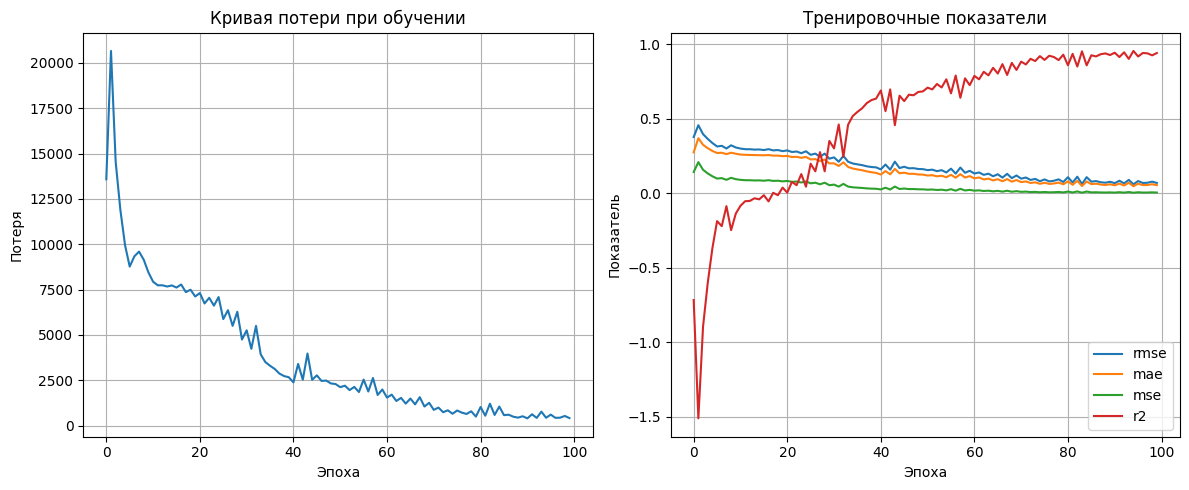

In [149]:
plot_training_history(
    train_results['train_loss'],
    titles=['Кривая потери при обучении', 'Тренировочные показатели'],
    metric_history={
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    },
)

100%|██████████| 22/22 [00:00<00:00, 686.53it/s]


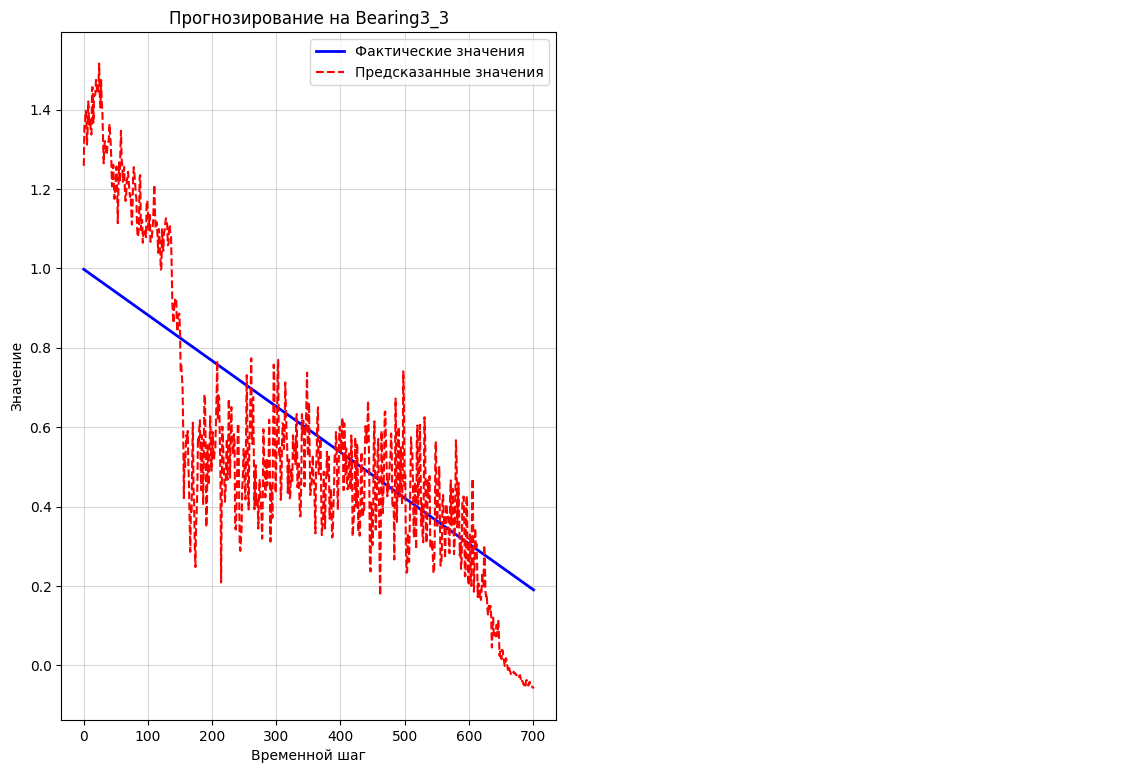

In [150]:
test_results = get_test_results(condition=3)

plot_predictions_grid(
    y_true_list=test_results['y_true_list'],
    y_pred_list=test_results['y_pred_list'],
    titles=test_results['titles'],
)

In [151]:
test_results['test_results_list']

[{'test_r2': [0.1833007991539276],
  'test_mae': [0.17513321],
  'test_mse': [0.044536386],
  'test_rmse': [0.21103646]}]